# Project 3 - Thermal inspection (classifying the defects) of photovoltaic modules

## Assignment 2 (preliminary delivery)

**Computer Vision**

Master in Data Science and Engineering - Faculdade de Engenharia da Universidade do Porto


Cátia Teixeira (200808037) |  Miguel Veloso (202202463)



---



## Introduction

The use of renewable energies has been on the rise in recent years, and one of the energy sources that stands out 
of this trend is solar energy, especially in countries where there is an abundance of sunlight.
As demand for solar energy increases, maintenance tasks naturally arise, which in some cases can be quite complex. In this particular case, in solar energy, the monitoring of the state of photovoltaic cells is done through photos, which are then manually classified according to the type of damage or disturbance to the cell - both of which have an impact on the ability to produce solar energy. One approach to make this maintenance more autonomous is through the use of Machine Learning or Deep Learning techniques, in which these algorithms automatically classify the type of damage or disturbance affecting a given cell.

The following classes are present in our dataset:



1.  **Cell Module**: a hot spot that appears in a single cell
2.   **Cell-Multi Module**: one of the hot spots in multiple cells
3.   **Cracking**: appeared on the surface of the module in single or multiple long-curve
4.    **Diode module**: activated bypass diode in about 1/3 area of the
module, which looks like a straight line in the IR image
5.   **Diode-Multi module**: activated bypass diode in about 2/3 area of the module
6.   **Hot-Spot module**: hot-spot in a thin film module
7. **Hot-Spot-Multi module**: multiple hot-spot in the thin-film module
8. **Offline module**: s heated entire the module (which looks like the No-anomaly module)
9. **Shadowing module**: blocked by vegetation or manmade structure
10. **Vegetation module**: blocked by vegetation (which is similar to the Shadowing module)
11. **Soiling module**: dirt or dust on the surface of the module (which looks like the Cell or Vegetation modules in the IR image)
12. **No-anomaly module**: Nominal solar module

There are 20,000 images with 40 × 24 pixels of each, and the no-anomaly images are half of it (10,000 images). Not only we have one class with half of the dataset but there is also 4 classes with less than 300 images, which is very short specially after splitting the dataset in train, validation and test (it will be mentioned later). Having in mind the previous, we were aware that it was going to be particularly challenging to get the models to learn to classify correctly.
The project is based on the article by Minhhuy Le, DucVu Le and Ha Thi Vu entitled "Thermal inspection of photovoltaic modules with deep convolutional neural networks on edge devices in AUV", in which they use a CNN model with data augmentation in the training images to detect anomalies. We presented a similar CNN, but slightly more complex (among other additions, we included dropout to deal with the overfitting issues). The dataset was divide in Train, Validation and Test with the proportions of (80/10/10), and we used the validation mainly to check for overfitting signs. Since the dataset is unbalanced, we used three techniques to deal with this issue, the first one was throught data augmentation, were it artificially increases the size of a dataset by applying various transformations to the existing data, then we used the class sensitive learning, that uses the different weights according with the number of samples of each class, classes with higher number of samples will receive a small weight whilist a class with a lower number of samples will receive a heigher weight. We would like to highlight the use of Generative Adversarial Network (GAN's) for balancing the dataset, in which realistic images artificially created by this model are generated for each of the classes, with the aim of combine these syntetic images with real images to training the model with these new images.
In addition to CNN, we also experimented with different types of pre-trained models, such as ResNet18, MobileNet and a VisualTransformer. These pre-trained models required a great deal of computing power, as was expected, even with most of their parameters frozen.
The following metrics were used to evaluate the results of all these models/experiences: Confusion Matrix, F1 Score, AUC and Accuracy.
The confusion matrix is essencial for an unbalanced dataset as it offers a comprehensive view of a model's strengths and weaknesses, aiding in the identification of specific error patterns and areas for improvement. The the F1 Score combines precision and recall into a single value, with higher scores indicating better overall model performance.






---



## Methodology

The following steps were not completed at the moment due to resource/time restrictions.

* Several sections of the report need to be completed (Introduction,conclusions, etc)
* Condition D is yet to be implemented.
* Pre-trained ResNET and pre-trained Transformer nedds additinal tunning and further implementation. 

In the following diagram we can see the proposed plan for this project.

<center><img src="updated_flow.jpg"/></center>

In [247]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
from torchinfo import summary
from torch.optim import Adam
import cv2
import numpy as np
from PIL import Image

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print ("Device is:", device)

Device is: cuda


In [4]:
import utils

In [5]:
import scprep
scprep.io.download.download_and_extract_zip(
   url="https://github.com/RaptorMaps/InfraredSolarModules/raw/master/2020-02-14_InfraredSolarModules.zip",
   destination=".")

In [5]:
metadata_path = "./InfraredSolarModules/module_metadata.json"
images_path = "./InfraredSolarModules/"
solar_dataset = utils.SolarDataset(metadata_path, images_path, random_state=42)

(20000, 2)


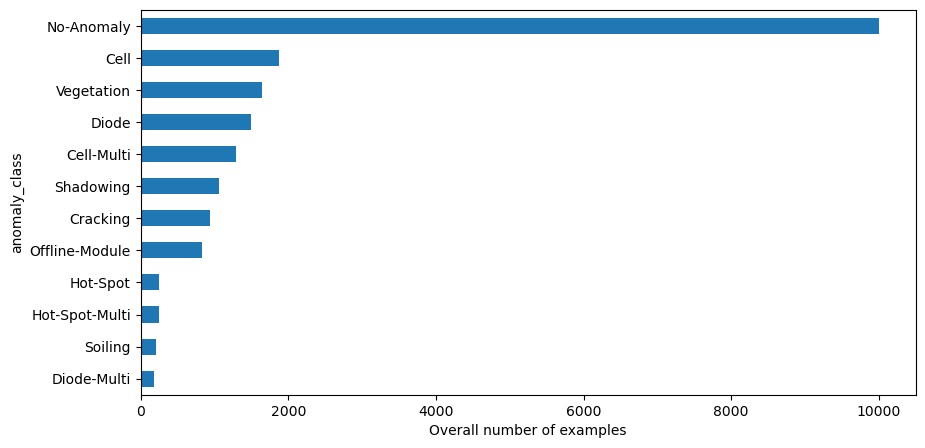

(12801, 2)


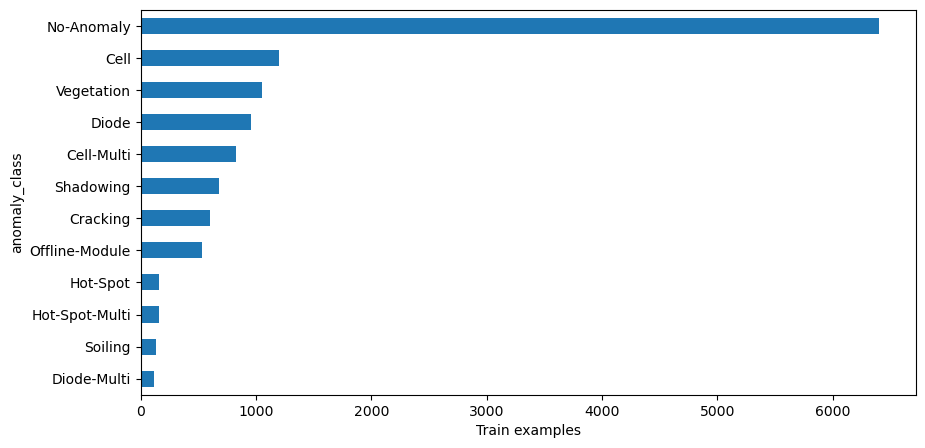

(3199, 2)


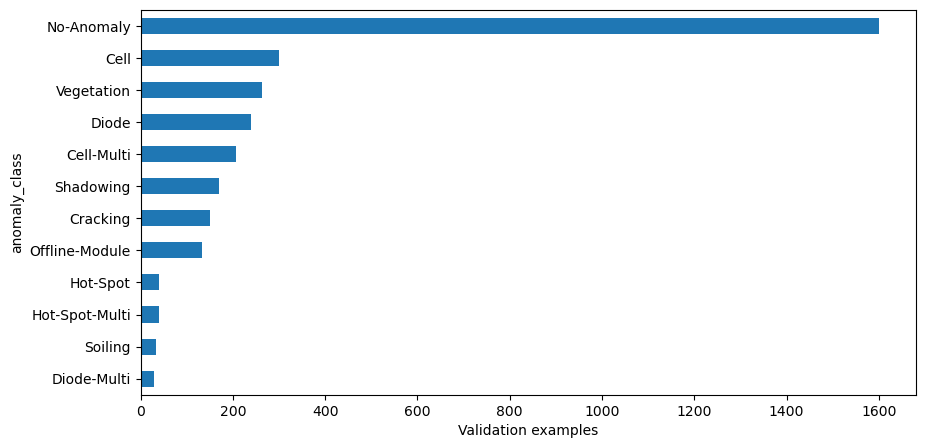

(4000, 2)


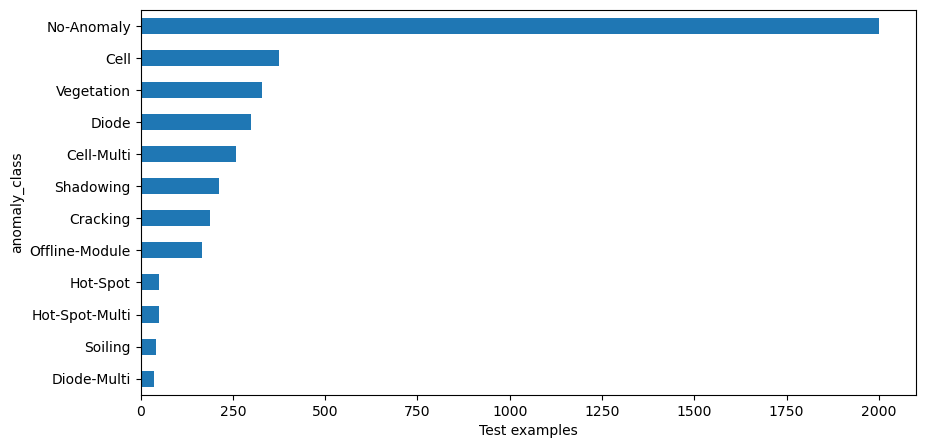

In [6]:
dfs_to_show = [
    [solar_dataset.full_df, "Overall number of examples"],
    [solar_dataset.train_df, "Train examples"],
    [solar_dataset.val_df, "Validation examples"],
    [solar_dataset.test_df, "Test examples"],
]

for (d, t) in dfs_to_show:
    ax = d.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
    ax.set_xlabel(t)
    print(d.shape)
    plt.show()

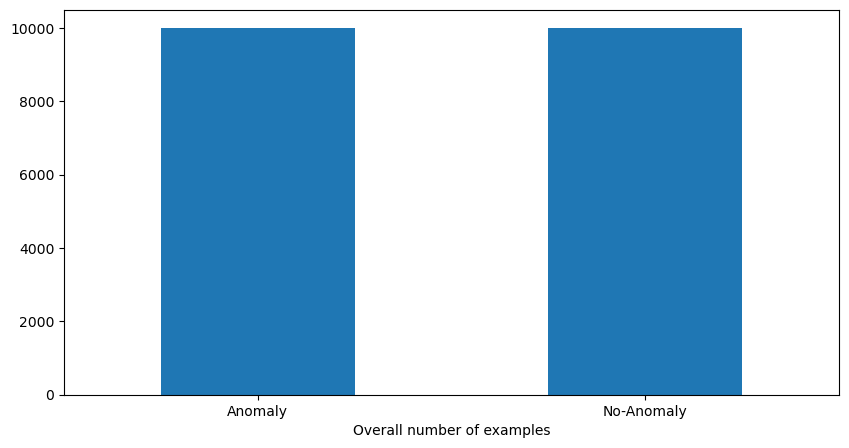

In [7]:
def convert_to_binary(x):
    x = 'Anomaly' if x != 'No-Anomaly' else x
    return x

df_binary = solar_dataset.full_df.copy()
df_binary['anomaly_class'] = solar_dataset.full_df.anomaly_class.apply(convert_to_binary)
ax = df_binary['anomaly_class'].value_counts().plot.bar(figsize=(10,5))
ax.tick_params(labelrotation=0)
ax.set_xlabel('Overall number of examples')
plt.show()

# Basic Pre-Processing

In [8]:
def preprocess_none(image, aug_number=0, label=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image[np.newaxis]
    return [image]

In [9]:
def preprocess_basic(image, aug_number=0, label=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = (image - 127.5) / 127.5
    image = image[np.newaxis]
    return [image]

# Defining Model from Paper

In [226]:
class PaperClassificator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            # BLock 1
            nn.Conv2d(in_dim[0], 80, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(80),
            # Block 2
            nn.Conv2d(80, 160, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(160),
            # Block 3
            nn.Conv2d(160, 320, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(320),
            # Block 4
            nn.Conv2d(320, 640, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(1, 2),
            nn.BatchNorm2d(640),
            # Average Pool
            nn.AvgPool2d(2),
            # Fully connected
            nn.Flatten(),
            nn.Linear(640, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.model(x)

## Running model from paper

In [227]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
paper_model = PaperClassificator(input_dim, output_dim).to(device)
print(summary(paper_model, (1, input_dim[0], input_dim[1], input_dim[2])))
paper_loss = torch.nn.CrossEntropyLoss()
paper_optimizer = Adam(paper_model.parameters(), lr=0.0003)
paper_train_test = utils.TrainTest(
    paper_model,
    paper_loss,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_none,
)

Layer (type:depth-idx)                   Output Shape              Param #
PaperClassificator                       [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 80, 40, 24]           800
│    └─ReLU: 2-2                         [1, 80, 40, 24]           --
│    └─MaxPool2d: 2-3                    [1, 80, 20, 12]           --
│    └─BatchNorm2d: 2-4                  [1, 80, 20, 12]           160
│    └─Conv2d: 2-5                       [1, 160, 20, 12]          115,360
│    └─ReLU: 2-6                         [1, 160, 20, 12]          --
│    └─MaxPool2d: 2-7                    [1, 160, 10, 6]           --
│    └─BatchNorm2d: 2-8                  [1, 160, 10, 6]           320
│    └─Conv2d: 2-9                       [1, 320, 10, 6]           461,120
│    └─ReLU: 2-10                        [1, 320, 10, 6]           --
│    └─MaxPool2d: 2-11                   [1, 320, 5, 3]            --
│ 

Loss = 2.0149195061789618   Accuracy= 0.6071428571428571
Best Epoch # 0  Validation Loss= 2.0149195061789618  Validation Accu= 0.6071428571428571
Loss = 1.971483380075485   Accuracy= 0.6480654761904762
Best Epoch # 1  Validation Loss= 1.971483380075485  Validation Accu= 0.6480654761904762
Loss = 1.9582862835081796   Accuracy= 0.6644345238095238
Best Epoch # 2  Validation Loss= 1.9582862835081796  Validation Accu= 0.6644345238095238
Loss = 1.9467497363923087   Accuracy= 0.669890873015873
Best Epoch # 3  Validation Loss= 1.9467497363923087  Validation Accu= 0.669890873015873
Loss = 1.9481919890358335   Accuracy= 0.6686507936507936
Loss = 1.9271904040896704   Accuracy= 0.6912202380952381
Best Epoch # 5  Validation Loss= 1.9271904040896704  Validation Accu= 0.6912202380952381
Loss = 1.9217007652161613   Accuracy= 0.6959325396825397
Best Epoch # 6  Validation Loss= 1.9217007652161613  Validation Accu= 0.6959325396825397
Loss = 1.9481198976910303   Accuracy= 0.6671626984126984
Loss = 1.91715

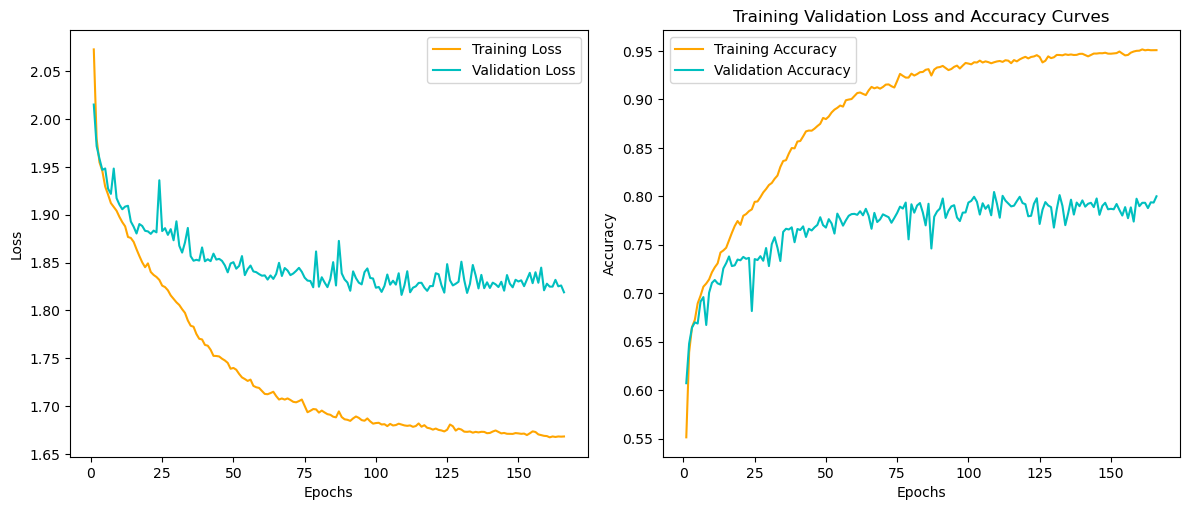

In [228]:
# Train Model
paper_best_loss, paper_best_accuracy, paper_best_epoch = paper_train_test.train(paper_optimizer, 166, "paper_model.pth")

Loss = 1.818983653235057   Accuracy= 0.7998511904761905


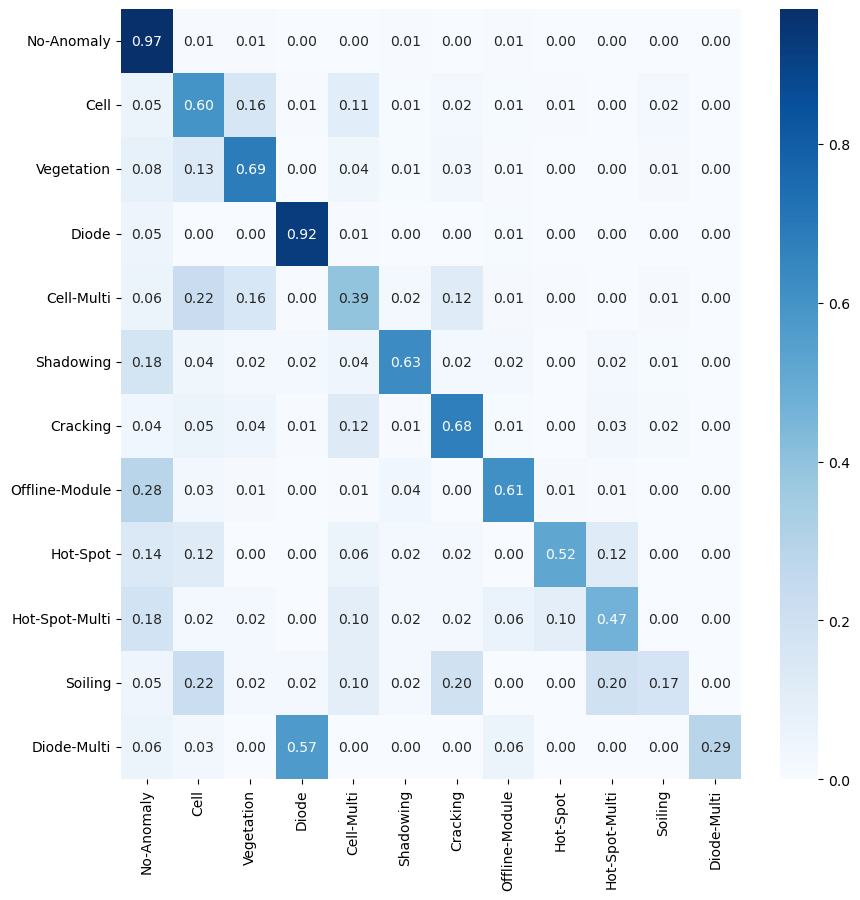

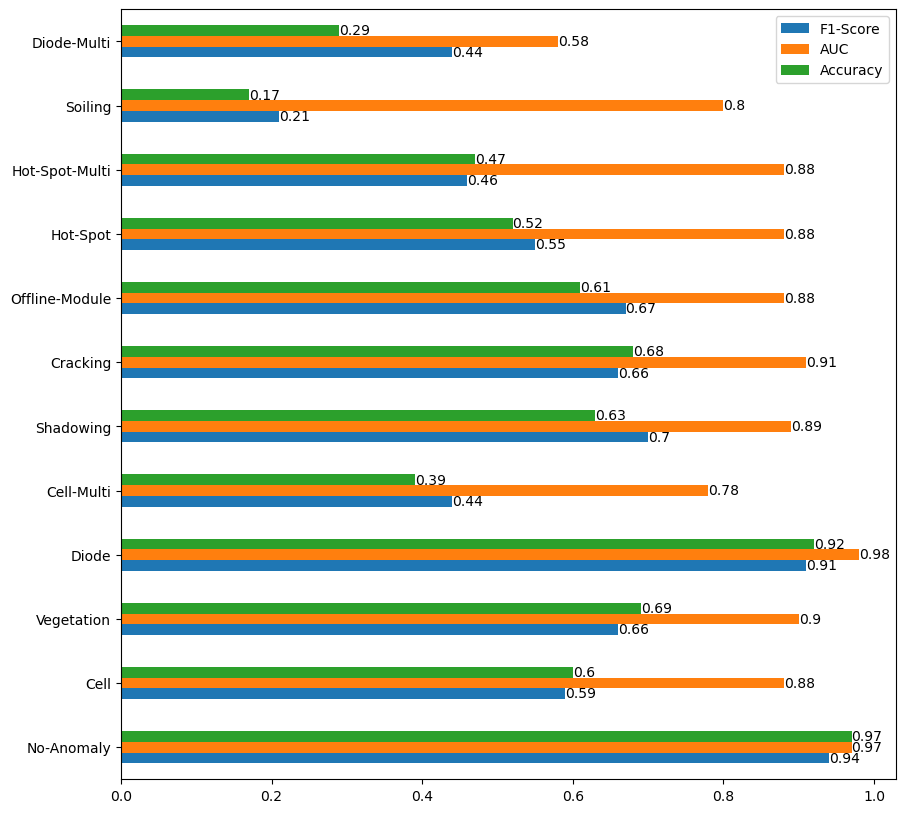

In [229]:
paper_train_test.test()
paper_train_test.plot_confusion_matrix()
paper_train_test.plot_class_metrics()

---

# Defining our CNN model

In [230]:
class OurClassificator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_dim[0], 60, 3, 1, 1),
            nn.BatchNorm2d(60),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.MaxPool2d(2, 2),
            # Input is Zx20x12
            nn.Conv2d(60, 120, 3, 1, 1),
            #nn.BatchNorm2d(120),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.MaxPool2d(2, 2),
            # Input is Zx10x6
            nn.Conv2d(120, 240, 3, 1, 1),
            #nn.BatchNorm2d(240),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.MaxPool2d(2, 2),
            # Input is Zx5x3
            nn.Conv2d(240, 480, (5, 3), 1, 0),
            #nn.BatchNorm2d(480),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Flatten(),
            nn.Linear(480, 960),
            nn.Sigmoid(),
            nn.Linear(960, out_dim),
        )

    def forward(self, x):
        return self.model(x)

In [231]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model = OurClassificator(input_dim, output_dim).to(device)
print(summary(our_model, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss = nn.BCEWithLogitsLoss().to(device)
our_optimizer = Adam(our_model.parameters(), lr=0.00003)
our_train_test = utils.TrainTest(
    our_model,
    our_loss,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_basic,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificator                         [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 60, 40, 24]           600
│    └─BatchNorm2d: 2-2                  [1, 60, 40, 24]           120
│    └─ReLU: 2-3                         [1, 60, 40, 24]           --
│    └─Dropout: 2-4                      [1, 60, 40, 24]           --
│    └─MaxPool2d: 2-5                    [1, 60, 20, 12]           --
│    └─Conv2d: 2-6                       [1, 120, 20, 12]          64,920
│    └─ReLU: 2-7                         [1, 120, 20, 12]          --
│    └─Dropout: 2-8                      [1, 120, 20, 12]          --
│    └─MaxPool2d: 2-9                    [1, 120, 10, 6]           --
│    └─Conv2d: 2-10                      [1, 240, 10, 6]           259,440
│    └─ReLU: 2-11                        [1, 240, 10, 6]           --
│   

Loss = 0.2172545413412745   Accuracy= 0.503968253968254
Best Epoch # 0  Validation Loss= 0.2172545413412745  Validation Accu= 0.503968253968254
Loss = 0.21037643059851632   Accuracy= 0.503968253968254
Loss = 0.20610929706266948   Accuracy= 0.503968253968254
Loss = 0.20160024956105246   Accuracy= 0.5228174603174603
Best Epoch # 3  Validation Loss= 0.20160024956105246  Validation Accu= 0.5228174603174603
Loss = 0.19617456434265015   Accuracy= 0.5339781746031746
Best Epoch # 4  Validation Loss= 0.19617456434265015  Validation Accu= 0.5339781746031746
Loss = 0.190410797203344   Accuracy= 0.5369543650793651
Best Epoch # 5  Validation Loss= 0.190410797203344  Validation Accu= 0.5369543650793651
Loss = 0.18602174827976833   Accuracy= 0.5483630952380952
Best Epoch # 6  Validation Loss= 0.18602174827976833  Validation Accu= 0.5483630952380952
Loss = 0.17763574687497957   Accuracy= 0.5639880952380952
Best Epoch # 7  Validation Loss= 0.17763574687497957  Validation Accu= 0.5639880952380952
Loss =

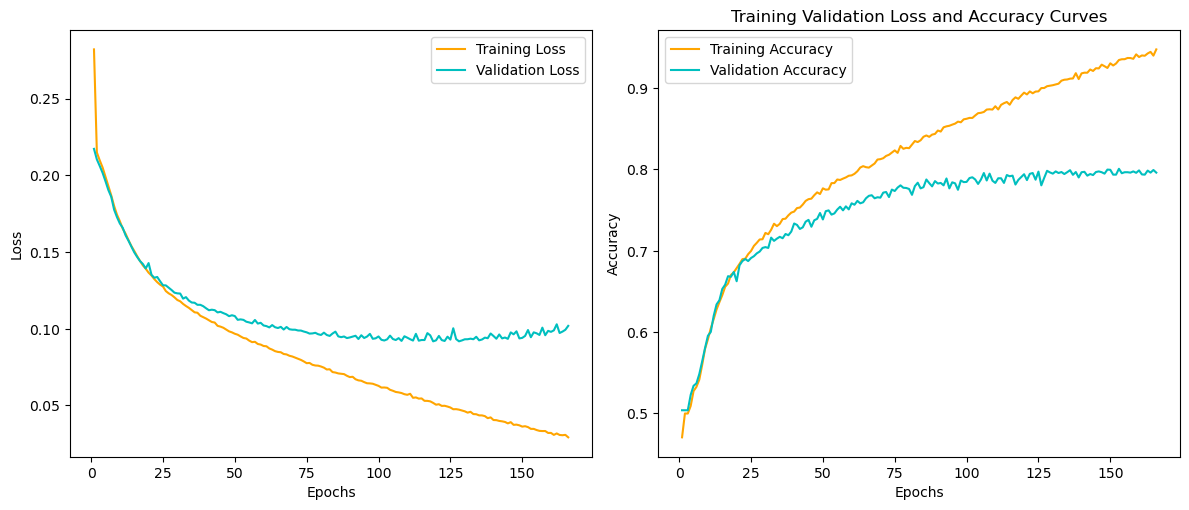

In [232]:
# Train Model
our_best_loss, our_best_accuracy, our_best_epoch = our_train_test.train(our_optimizer, 166, "our_model.pth")

Loss = 0.09449409280297538   Accuracy= 0.8005952380952381


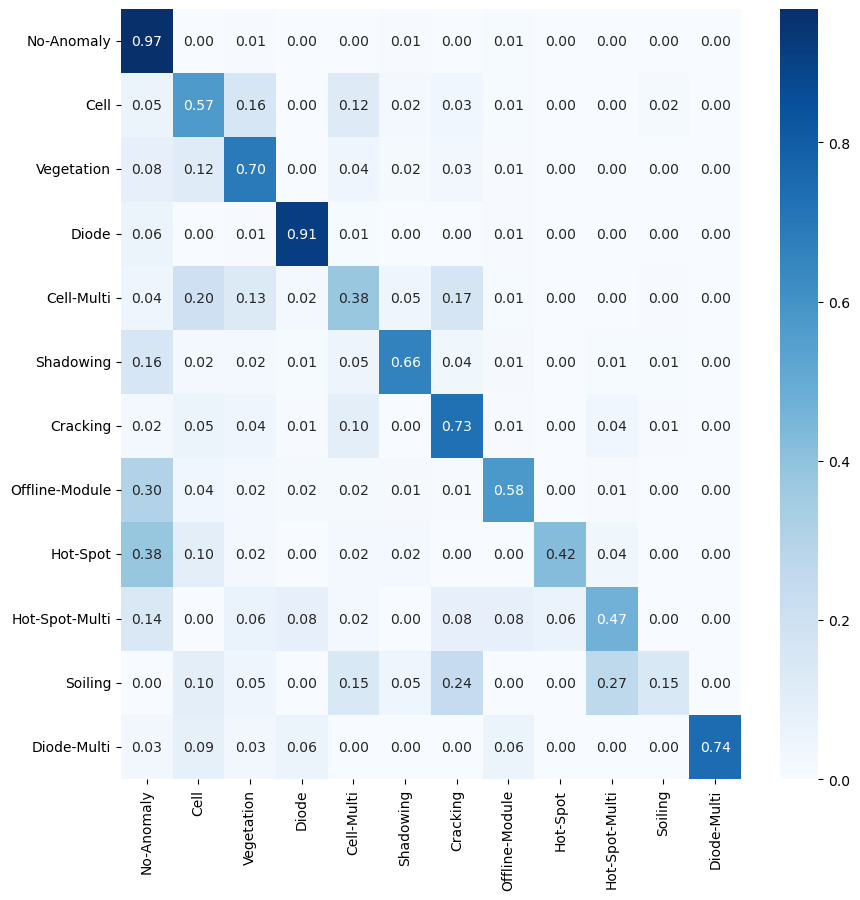

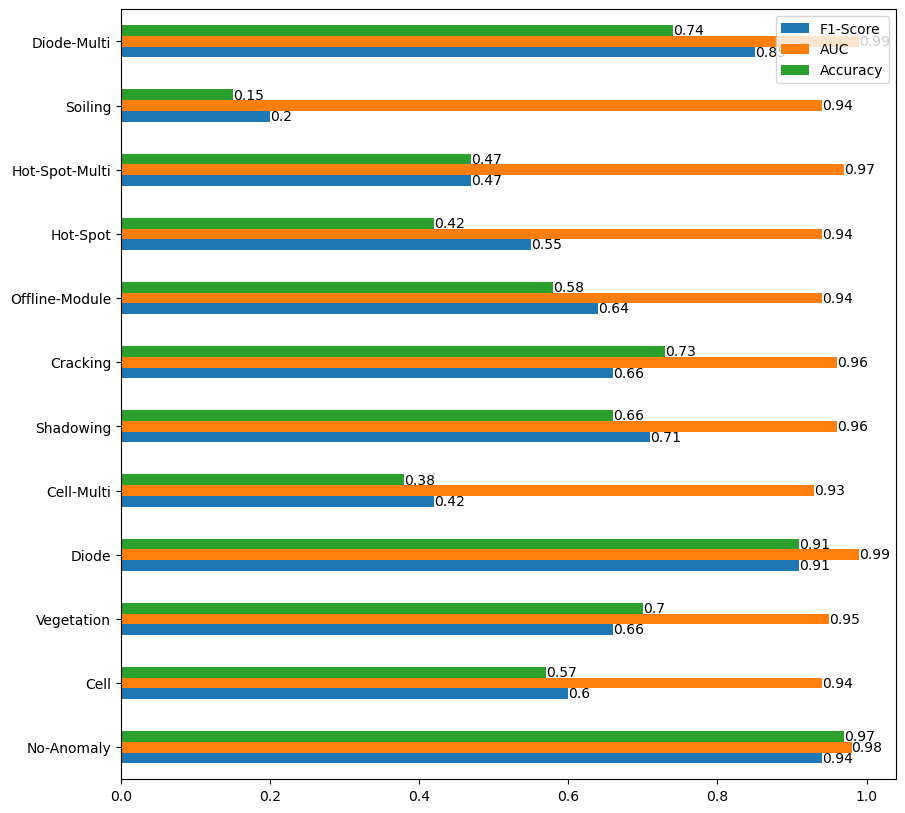

In [246]:
our_train_test.test()
our_train_test.plot_confusion_matrix()
our_train_test.plot_class_metrics()

---

# Adding Class Sensitive Learning (condition B)

In [234]:
total_imgs = len(solar_dataset.train_df)
class_weights = np.zeros(solar_dataset.num_classes)
for k, v in dict(solar_dataset.train_df.anomaly_class.value_counts()).items():
    class_weights[solar_dataset.classes_list.index(k)] = v
class_weights = torch.tensor([total_imgs/(class_imgs*solar_dataset.num_classes) for class_imgs in class_weights]).to(device)
print(class_weights)
print(solar_dataset.classes_list)

tensor([0.1667, 0.8875, 1.0169, 1.1124, 1.2946, 1.5780, 1.7720, 2.0127, 6.7091,
        6.7516, 8.2058, 9.5246], device='cuda:0', dtype=torch.float64)
['No-Anomaly', 'Cell', 'Vegetation', 'Diode', 'Cell-Multi', 'Shadowing', 'Cracking', 'Offline-Module', 'Hot-Spot', 'Hot-Spot-Multi', 'Soiling', 'Diode-Multi']


In [235]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model_w = OurClassificator(input_dim, output_dim).to(device)
print(summary(our_model_w, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss_w = nn.BCEWithLogitsLoss(weight=class_weights)
our_optimizer_w = Adam(our_model_w.parameters(), lr=0.00003)
our_train_test_w = utils.TrainTest(
    our_model_w,
    our_loss_w,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_basic,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificator                         [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 60, 40, 24]           600
│    └─BatchNorm2d: 2-2                  [1, 60, 40, 24]           120
│    └─ReLU: 2-3                         [1, 60, 40, 24]           --
│    └─Dropout: 2-4                      [1, 60, 40, 24]           --
│    └─MaxPool2d: 2-5                    [1, 60, 20, 12]           --
│    └─Conv2d: 2-6                       [1, 120, 20, 12]          64,920
│    └─ReLU: 2-7                         [1, 120, 20, 12]          --
│    └─Dropout: 2-8                      [1, 120, 20, 12]          --
│    └─MaxPool2d: 2-9                    [1, 120, 10, 6]           --
│    └─Conv2d: 2-10                      [1, 240, 10, 6]           259,440
│    └─ReLU: 2-11                        [1, 240, 10, 6]           --
│   

Loss = 0.3504732505433143   Accuracy= 0.503968253968254
Best Epoch # 0  Validation Loss= 0.3504732505433143  Validation Accu= 0.503968253968254
Loss = 0.34360394591376897   Accuracy= 0.503968253968254
Loss = 0.34260869877679007   Accuracy= 0.503968253968254
Loss = 0.34220331966403933   Accuracy= 0.503968253968254
Loss = 0.3415610358592064   Accuracy= 0.503968253968254
Loss = 0.3402047011823881   Accuracy= 0.503968253968254
Loss = 0.33856913955911755   Accuracy= 0.503968253968254
Loss = 0.33696451996053967   Accuracy= 0.503968253968254
Loss = 0.33406486953534775   Accuracy= 0.503968253968254
Loss = 0.33017738967660876   Accuracy= 0.5069444444444444
Best Epoch # 9  Validation Loss= 0.33017738967660876  Validation Accu= 0.5069444444444444
Loss = 0.3260284009433928   Accuracy= 0.5153769841269841
Best Epoch # 10  Validation Loss= 0.3260284009433928  Validation Accu= 0.5153769841269841
Loss = 0.3205948955719433   Accuracy= 0.5295138888888888
Best Epoch # 11  Validation Loss= 0.32059489557194

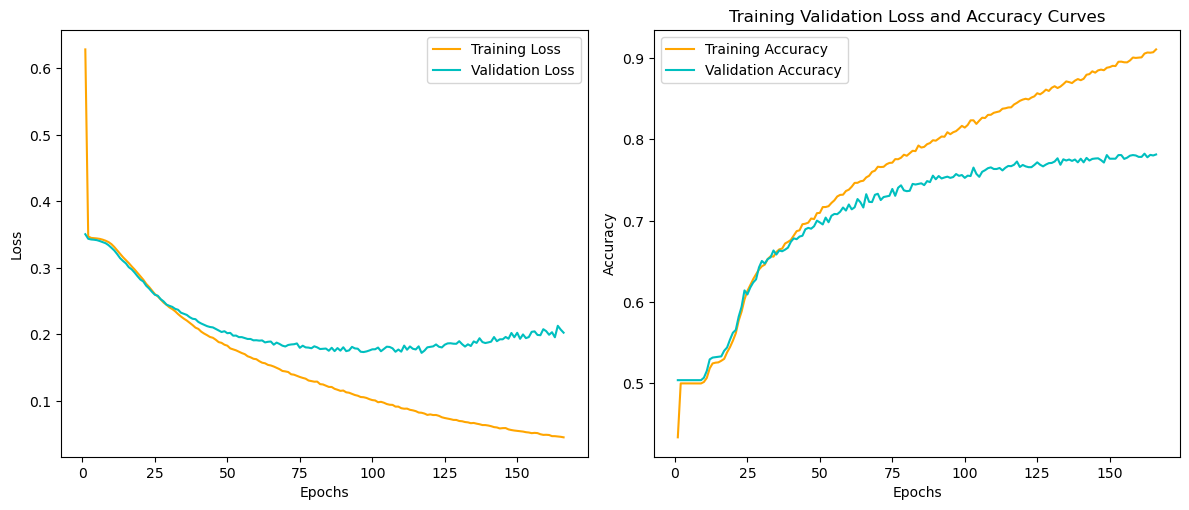

In [236]:
# Train Model
our_best_w_loss, our_best_w_accuracy, our_best_w_epoch = our_train_test_w.train(our_optimizer_w, 166, "our_model_w.pth")

Loss = 0.20258499746994366   Accuracy= 0.7814980158730159


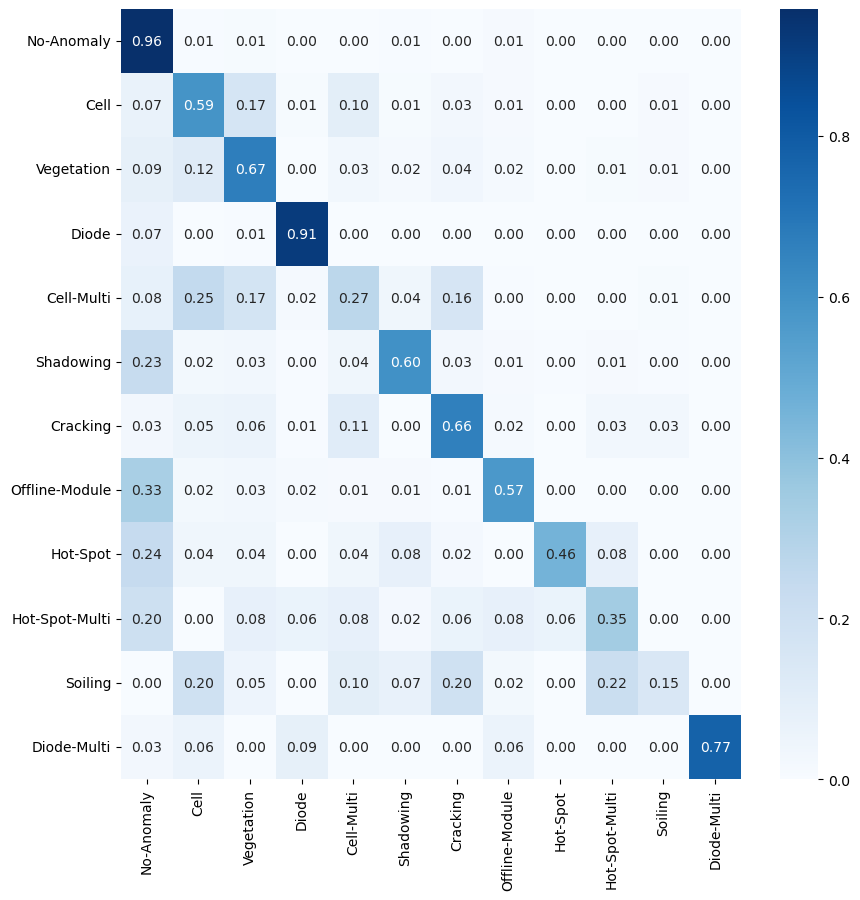

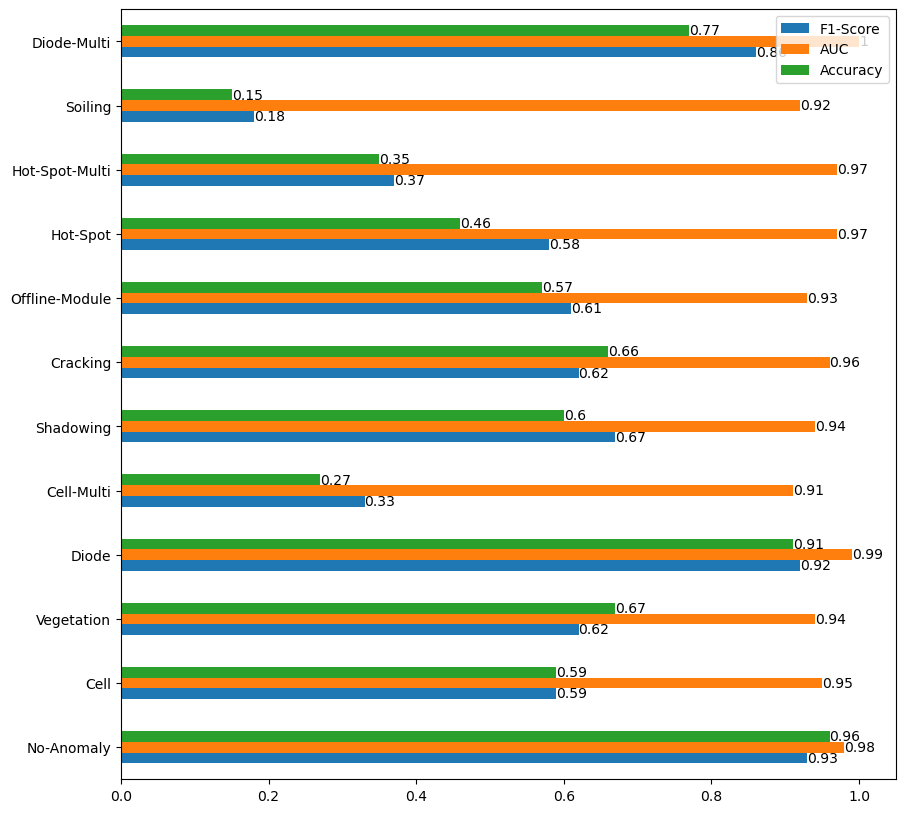

In [237]:
our_train_test_w.test()
our_train_test_w.plot_confusion_matrix()
our_train_test_w.plot_class_metrics()

---

# Adding Data Augmentation (condition C)

### Traditional data augmentation techniques

We first start with our baseline model, without using any data augmentation, however and since our dataset is relatively small, speacially if we consider that half of the dataset is only for one class (10000 samples for Non Anomaly Class), we decided to do some experiments with data augmentation.
Applying data augmentation usually provide better results since it increases the training set size by generating additional training samples by applying transformations such as rotation, flipping, scaling, and cropping to the original images. This increases the diversity of the dataset, which can be particularly beneficial when working with limited labeled data.

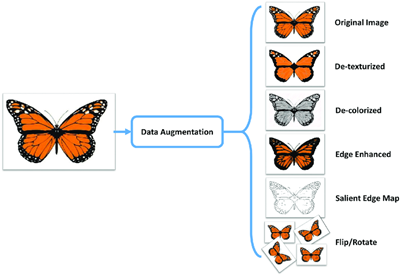

Below a few types of transformations were defined, some had more success than others (increasing or decreasing the model accuracy).
<br><br>
**RandomRotation**(degrees) : Rotate the image by angle.   
degrees : Range of degrees to select from. If degrees is a number instead of sequence like (min, max), the range of degrees will be (-degrees, +degrees).

**RandomHorizontalFlip**(p) : Horizontally flip the given PIL Image randomly with a given probability p

**RandomVertitalFlip**(p) : Vertitally flip the given PIL Image randomly with a given probability p

**ColorJitter**(brightness=0, contrast=0, saturation=0, hue=0) :
Randomly change the brightness, contrast and saturation of an image.
The parameters describe how much to jitter.



In [239]:
def preprocess_augment(image, aug_number=0, label=None):
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            transforms.ToTensor(),
            transforms.Grayscale(),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Grayscale(),
        ])
    ]

    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

In [240]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model_aug = OurClassificator(input_dim, output_dim).to(device)
print(summary(our_model_aug, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss_aug = nn.BCEWithLogitsLoss()
our_optimizer_aug = Adam(our_model_aug.parameters(), lr=0.00003)
our_train_test_aug = utils.TrainTest(
    our_model_aug,
    our_loss_aug,
    32,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_augment,
    augment=True,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificator                         [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 60, 40, 24]           600
│    └─BatchNorm2d: 2-2                  [1, 60, 40, 24]           120
│    └─ReLU: 2-3                         [1, 60, 40, 24]           --
│    └─Dropout: 2-4                      [1, 60, 40, 24]           --
│    └─MaxPool2d: 2-5                    [1, 60, 20, 12]           --
│    └─Conv2d: 2-6                       [1, 120, 20, 12]          64,920
│    └─ReLU: 2-7                         [1, 120, 20, 12]          --
│    └─Dropout: 2-8                      [1, 120, 20, 12]          --
│    └─MaxPool2d: 2-9                    [1, 120, 10, 6]           --
│    └─Conv2d: 2-10                      [1, 240, 10, 6]           259,440
│    └─ReLU: 2-11                        [1, 240, 10, 6]           --
│   

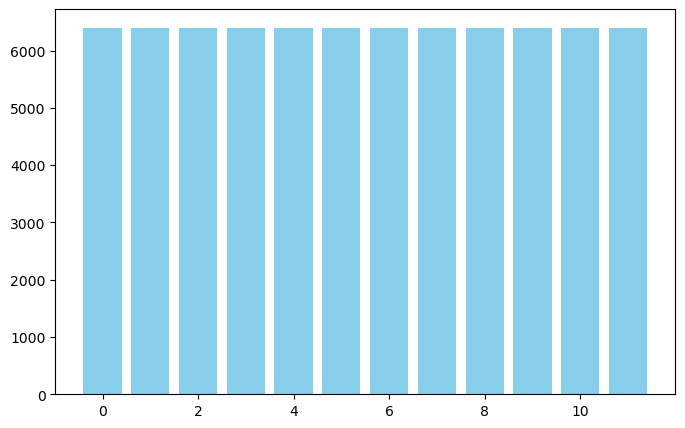

6400 6400


In [241]:
labels = []
for _, target in our_train_test_aug.train_dataloader:
    labels.extend(target.numpy())

counts = {}
for l in labels:
    if l not in counts:
        counts[l] = 0
    counts[l] += 1

class_l = list(counts.keys())
counts = list(counts.values())

plt.figure(figsize=(8,5))
plt.bar(class_l, counts, color="skyblue")
plt.show()

print(np.max(counts), np.min(counts))

Loss = 0.2335969067811966   Accuracy= 0.3685
Best Epoch # 0  Validation Loss= 0.2335969067811966  Validation Accu= 0.3685
Loss = 0.19758631706237792   Accuracy= 0.47
Best Epoch # 1  Validation Loss= 0.19758631706237792  Validation Accu= 0.47
Loss = 0.1854154703617096   Accuracy= 0.5225
Best Epoch # 2  Validation Loss= 0.1854154703617096  Validation Accu= 0.5225
Loss = 0.16858361178636552   Accuracy= 0.588
Best Epoch # 3  Validation Loss= 0.16858361178636552  Validation Accu= 0.588
Loss = 0.16475652274489402   Accuracy= 0.58875
Best Epoch # 4  Validation Loss= 0.16475652274489402  Validation Accu= 0.58875
Loss = 0.16987168696522711   Accuracy= 0.5725
Loss = 0.1499275867640972   Accuracy= 0.6295
Best Epoch # 6  Validation Loss= 0.1499275867640972  Validation Accu= 0.6295
Loss = 0.14534985199570655   Accuracy= 0.6535
Best Epoch # 7  Validation Loss= 0.14534985199570655  Validation Accu= 0.6535
Loss = 0.1329542365670204   Accuracy= 0.6845
Best Epoch # 8  Validation Loss= 0.1329542365670204

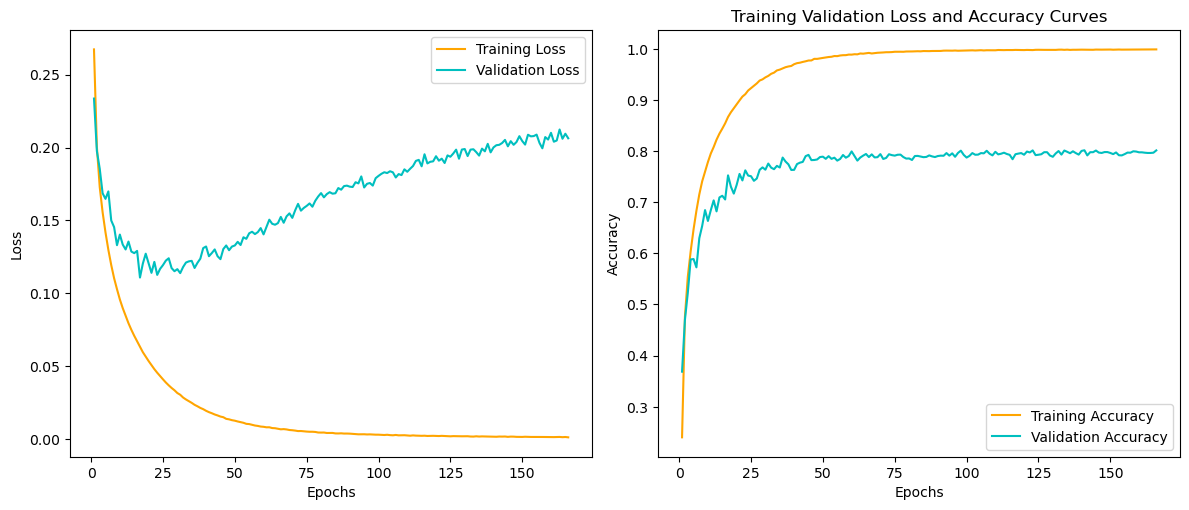

In [242]:
# Train Model
our_best_aug_loss, our_best_aug_accuracy, our_best_aug_epoch = our_train_test_aug.train(our_optimizer_aug, 166, "our_model_aug.pth")

Loss = 0.20633464460074902   Accuracy= 0.80125


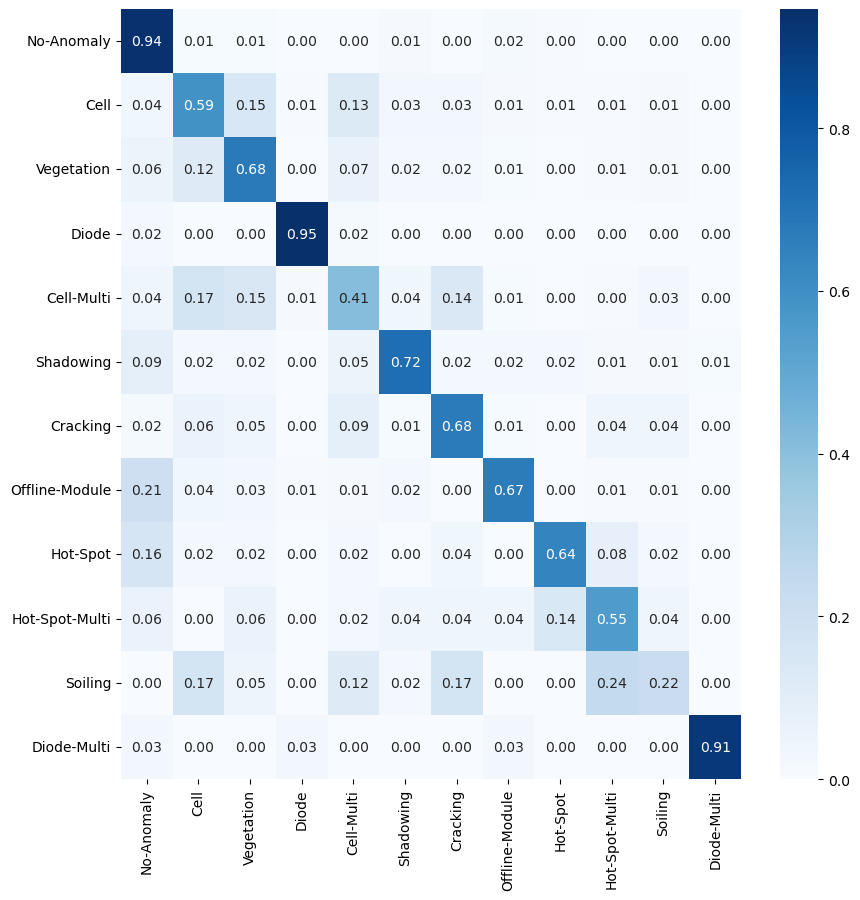

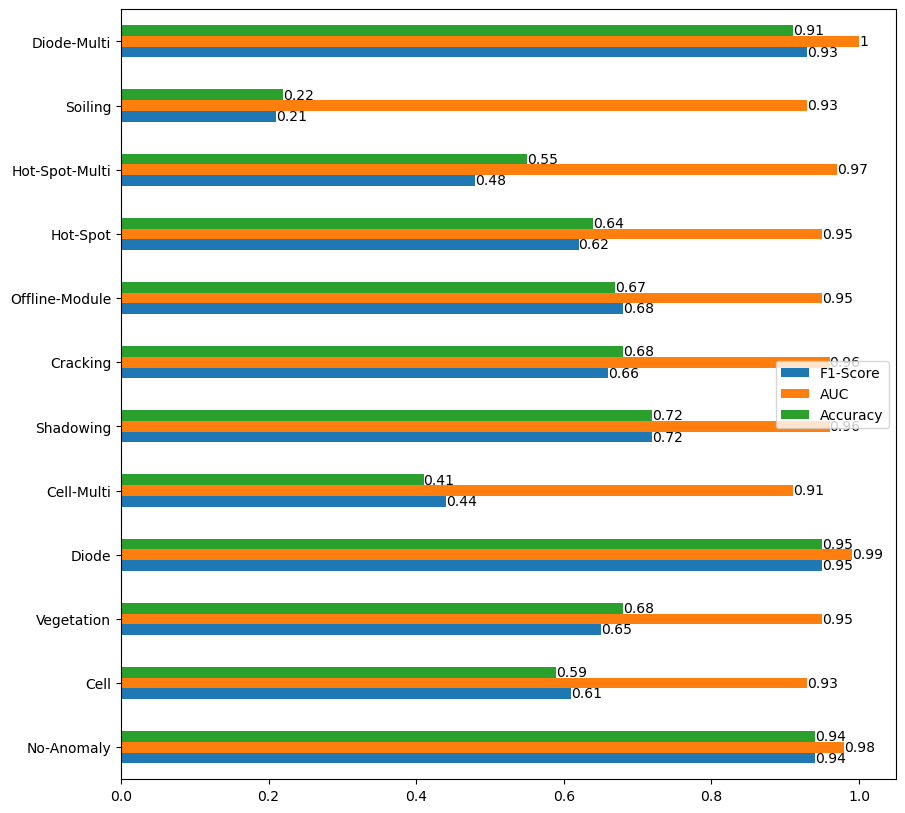

In [243]:
our_train_test_aug.test()
our_train_test_aug.plot_confusion_matrix()
our_train_test_aug.plot_class_metrics()

---

# Data Augmentation (Condition D)

Using GAN's for Data Augmentation

In [271]:
def preprocess_gan(image, aug_number=0, label=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    image = (image - 127.5) / 127.5
    image = image[np.newaxis]
    return [image]

In [296]:
class GAugmented(nn.Module):
    def __init__(self, img_shape, solar_dataset, latent_dim=100, features_gen=20, features_disc=20):
        super().__init__()
        self.img_size = img_shape[0] * img_shape[1] * img_shape[2]
        self.features_gen = features_gen
        self.features_disc = features_disc
        self.generator = self.Generator(latent_dim, img_shape, img_shape[0], features_gen, solar_dataset.num_classes).to(device)
        self.generator.weight_init(mean=0.0, std=0.02)
        self.discriminator = self.Discriminator(img_shape[0], features_disc, solar_dataset.num_classes).to(device)
        self.discriminator.weight_init(mean=0.0, std=0.02)
        self.lr_gen = 0.0002
        self.lr_disc = 0.0002
        self.batch_size = 128
        self.latent_dim = latent_dim
        self.img_shape = img_shape
        self.solar_dataset = solar_dataset

        print(summary(self.generator,
                [(1, latent_dim, 1, 1), (1, solar_dataset.num_classes, 1, 1)]))
        print(summary(self.discriminator,
                [(1, img_shape[0], img_shape[1], img_shape[2]),
                 (1, solar_dataset.num_classes, img_shape[1], img_shape[2])]))

        # Optimizers and loss function
        beta1 = 0.50
        self.optimizer_g = torch.optim.Adam(self.generator.parameters(), lr=self.lr_gen, betas=(beta1, 0.999))
        self.optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr_disc, betas=(beta1, 0.999))
        self.adversarial_loss = nn.BCELoss()

        # One hot encoded labels
        self.fill_d = torch.zeros([self.solar_dataset.num_classes, self.solar_dataset.num_classes, img_shape[1], img_shape[2]]).to(device)
        self.fill_g = torch.zeros([self.solar_dataset.num_classes, self.solar_dataset.num_classes, 1, 1]).to(device)
        for i in range(self.solar_dataset.num_classes):
            self.fill_d[i, i, :, :] = 1
            self.fill_g[i, i, :, :] = 1

    def fit(self, dataloader, epochs=500):
        fit_total_loss_gen = []
        fit_total_loss_disc = []

        for epoch in range(epochs):
            loss_gen = 0
            loss_disc = 0
            for i, (real_imgs, real_labels) in enumerate(dataloader):
                real_imgs = real_imgs.to(device)
                real_labels = real_labels.to(device)
                batch_size = real_imgs.size(0)

                # Adversarial ground truths, with label smoothing
                fake = torch.autograd.Variable(torch.zeros(batch_size, 1)).to(device)
                valid = torch.autograd.Variable(torch.ones(batch_size, 1)).to(device)

                # Train discriminator
                self.optimizer_d.zero_grad()

                # Generate fake data
                z = torch.autograd.Variable(torch.randn(batch_size, self.latent_dim, 1, 1)).to(device)

                # Labels fake and real
                label_real_disc = torch.autograd.Variable(self.fill_d[real_labels.to(torch.int64)]).to(device)
                label_fake_disc = torch.autograd.Variable(self.fill_d[real_labels.to(torch.int64)]).to(device)
                label_fake_gen = torch.autograd.Variable(self.fill_g[real_labels.to(torch.int64)]).to(device)

                # Generate samples
                gen_imgs = self.generator(z, label_fake_gen)

                # Use real samples
                output_real = self.discriminator(real_imgs, label_real_disc)
                loss_real = self.adversarial_loss(output_real, valid)
                loss_real.backward()

                # Use fake samples
                output_fake = self.discriminator(gen_imgs.detach(), label_fake_disc)
                loss_fake = self.adversarial_loss(output_fake, fake)
                loss_fake.backward()

                # For informative purposes, save the average loss
                total_loss_disc = 0.5 * (loss_real + loss_fake)

                # Back propagate loss           
                self.optimizer_d.step()

                # Train generator
                self.optimizer_g.zero_grad()

                # Generate fake data
                z = torch.autograd.Variable(torch.randn(batch_size, self.latent_dim, 1, 1)).to(device)
                fake_labels = torch.autograd.Variable(torch.FloatTensor(np.random.randint(0, self.solar_dataset.num_classes, batch_size))).to(device)

                # Labels fake and real
                label_fake_disc = torch.autograd.Variable(self.fill_d[fake_labels.to(torch.int64)]).to(device)
                label_fake_gen = torch.autograd.Variable(self.fill_g[fake_labels.to(torch.int64)]).to(device)

                # Generate samples
                gen_imgs = self.generator(z, label_fake_gen)

                # Train generator
                output_fake_generator = self.discriminator(gen_imgs, label_fake_disc)
                loss_generator = self.adversarial_loss(output_fake_generator, valid)
                loss_generator.backward()

                # For informative purposes, save the loss
                total_loss_generator = loss_generator

                # Back propagate loss
                self.optimizer_g.step()

                # Save for information
                loss_gen += total_loss_generator.item()
                loss_disc += total_loss_disc.item()

            loss_gen = loss_gen / len(dataloader)
            loss_disc = loss_disc / len(dataloader)
            fit_total_loss_gen.append(loss_gen)
            fit_total_loss_disc.append(loss_disc)

            print(f"[Epoch {epoch}/{epochs}]"
                  f" [D loss: {loss_disc}] [G loss: {loss_gen}]")

            if epoch % 10 == 0:
                torch.save(self.state_dict(), "gan_model_temporary.pth")
                plt.figure(figsize=(15,15))
                for j in range(self.solar_dataset.num_classes):
                    image = self.augment(1, j)[0].cpu().numpy()
                    plt.subplot(6, 6, j+1)
                    plt.imshow((image.transpose(1, 2, 0) + 1.0) / 2.0)
                    plt.title(self.solar_dataset.classes_list[j])
                    plt.axis('off')
                plt.show()

        return fit_total_loss_gen, fit_total_loss_disc

    def augment(self, num, cat):
        def batch(iterable, n=1):
            l = len(iterable)
            for ndx in range(0, l, n):
                yield iterable[ndx:min(ndx + n, l)]

        with torch.no_grad():
            self.generator.eval()
            gen_imgs = []
            for x_num in batch(range(num), n=100):
                n = len(x_num)
                z = torch.randn(n, self.latent_dim, 1, 1).to(device)
                c = torch.tensor(cat).repeat(n)
                l_g = self.fill_g[c.to(torch.int64)]
                gen = self.generator(z, l_g)
                for g in gen:
                    gen_imgs.append(g.view(self.img_shape[0], self.img_shape[1], self.img_shape[2]))
            return gen_imgs

    class Generator(nn.Module):
        def __init__(self, in_dim, out_shape, out_size, features, cats):
            super().__init__()
            self.in_dim = in_dim
            self.out_size = out_size
            self.out_shape = out_shape
            self.ngf = features
            self.cats = cats
            self.model_x = nn.Sequential(
                nn.Flatten(),
                nn.Linear(self.in_dim, self.ngf*8*1*1),
                nn.ReLU(),
            )
            self.model_y = nn.Sequential(
                nn.Flatten(),
                nn.Linear(self.cats, self.ngf*8*1*1),
                nn.ReLU(),
            )
            self.model_f = nn.Sequential(
                # Input is Zx1x1
                nn.ConvTranspose2d(self.ngf*16, self.ngf*16, (5, 3), 1, 0),
                #nn.BatchNorm2d(self.ngf*16),
                nn.ReLU(),
                
                # Input is Zx5x3
                nn.ConvTranspose2d(self.ngf*16, self.ngf*16, 4, 2, 1),
                #nn.BatchNorm2d(self.ngf*16),
                nn.ReLU(),
                
                # Input is Zx10x6
                nn.ConvTranspose2d(self.ngf*16, self.ngf*16, 4, 2, 1),
                #nn.BatchNorm2d(self.ngf*16),
                nn.ReLU(),
                
                # Input is Zx20x12
                nn.ConvTranspose2d(self.ngf*16, self.out_size, 4, 2, 1),

                # Input is 1x40x24
                nn.Tanh(),
            )

        def weight_init(self, mean, std):
            for m in self._modules:
                self.normal_init(self._modules[m], mean, std)

        def normal_init(self, m, mean, std):
            if isinstance(m, nn.Sequential):
                for l in m:
                    if isinstance(l, nn.ConvTranspose2d) or isinstance(l, nn.Conv2d):
                        l.weight.data.normal_(mean, std)
                        print(l)
                    if isinstance(l, nn.BatchNorm2d):
                        l.bias.data.zero_()
                        print(l)

        def forward(self, z, cat):
            x = self.model_x(z)
            y = self.model_y(cat)
            img = self.model_f(torch.cat([x.view(-1, self.ngf*8, 1, 1), y.view(-1, self.ngf*8, 1, 1)], 1))
            return img.view(-1, self.out_shape[0], self.out_shape[1], self.out_shape[2])

    class Discriminator(nn.Module):
        def __init__(self, in_dim, features, cats):
            super().__init__()
            self.in_dim = in_dim
            self.ndf = features
            self.cats = cats
            self.model_x = nn.Sequential(
                nn.Conv2d(self.in_dim, self.ndf*8, 4, 2, 1),
                nn.LeakyReLU(0.2),
            )
            self.model_y = nn.Sequential(
                nn.Conv2d(self.cats, self.ndf*8, 4, 2, 1),
                nn.LeakyReLU(0.2),
            )
            self.model_f = nn.Sequential(
                # Input is Zx20x12
                nn.Conv2d(self.ndf*16, self.ndf*16, 2, 2, "valid"),
                #nn.BatchNorm2d(self.ndf*16),
                nn.LeakyReLU(0.2),
                
                # Input is Zx10x6
                nn.Conv2d(self.ndf*16, self.ndf*16, 2, 2, "valid"),
                #nn.BatchNorm2d(self.ndf*16),
                nn.LeakyReLU(0.2),
                
                # Input is Zx5x3
                nn.Flatten(),
                nn.Linear(self.ndf*16*5*3, 1),
                nn.Sigmoid(),
            )

        def weight_init(self, mean, std):
            for m in self._modules:
                self.normal_init(self._modules[m], mean, std)

        def normal_init(self, m, mean, std):
            if isinstance(m, nn.Sequential):
                for l in m:
                    if isinstance(l, nn.ConvTranspose2d) or isinstance(l, nn.Conv2d):
                        l.weight.data.normal_(mean, std)
                        print(l)
                    if isinstance(l, nn.BatchNorm2d):
                        l.bias.data.zero_()
                        print(l)

        def forward(self, x, cat):
            x = self.model_x(x)
            y = self.model_y(cat)
            out = self.model_f(torch.cat([x, y], 1))
            return out.view(out.size(0), -1)

In [297]:
input_dim = (1, 40, 24)
g_model = GAugmented(input_dim, solar_dataset).to(device)
solar_dataset_gan = utils.SolarDataset(metadata_path, images_path, random_state=42)
g_train_test = utils.TrainTest(
    g_model,
    None,
    g_model.batch_size,
    solar_dataset_gan,
    solar_dataset_gan.train_df,
    device,
    pre_process=preprocess_gan,
)

ConvTranspose2d(320, 320, kernel_size=(5, 3), stride=(1, 1))
ConvTranspose2d(320, 320, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
ConvTranspose2d(320, 320, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
ConvTranspose2d(320, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Conv2d(1, 160, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Conv2d(12, 160, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
Conv2d(320, 320, kernel_size=(2, 2), stride=(2, 2), padding=valid)
Conv2d(320, 320, kernel_size=(2, 2), stride=(2, 2), padding=valid)
Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 40, 24]            --
├─Sequential: 1-1                        [1, 160]                  --
│    └─Flatten: 2-1                      [1, 100]                  --
│    └─Linear: 2-2                       [1, 160]                  16,160
│    └─ReLU: 2-3                         [1, 160]                  --
├─Sequential: 

[Epoch 0/200] [D loss: 0.6858014844357967] [G loss: 0.9137070155143738]


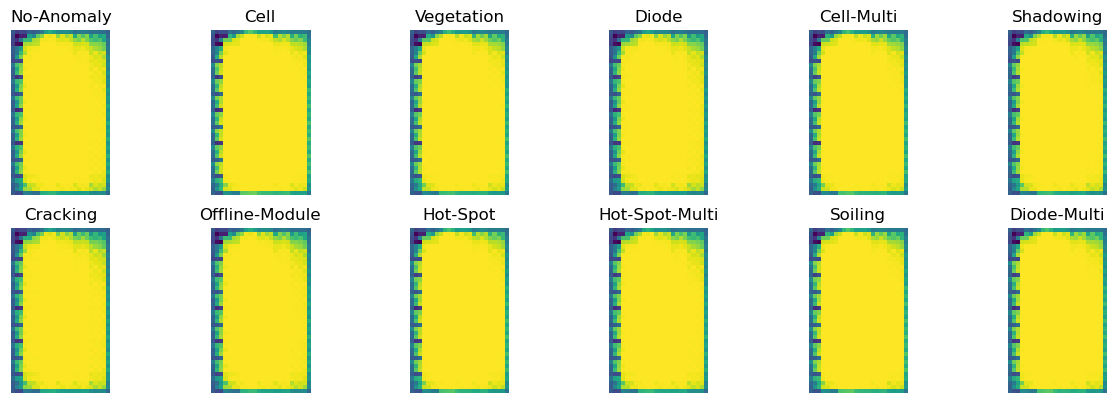

[Epoch 1/200] [D loss: 0.6797975099086762] [G loss: 0.8236658179759979]
[Epoch 2/200] [D loss: 0.67556884765625] [G loss: 0.7330576038360596]
[Epoch 3/200] [D loss: 0.6836614799499512] [G loss: 0.8808836150169372]
[Epoch 4/200] [D loss: 0.6851956391334534] [G loss: 0.7458438444137573]
[Epoch 5/200] [D loss: 0.6884708744287491] [G loss: 0.7472337824106217]
[Epoch 6/200] [D loss: 0.6798348885774612] [G loss: 0.8324101102352143]
[Epoch 7/200] [D loss: 0.685406687259674] [G loss: 0.7739318877458572]
[Epoch 8/200] [D loss: 0.6829109013080596] [G loss: 0.8251016283035278]
[Epoch 9/200] [D loss: 0.6723754012584686] [G loss: 1.1274900214374066]
[Epoch 10/200] [D loss: 0.6793646371364593] [G loss: 0.7725814563035965]


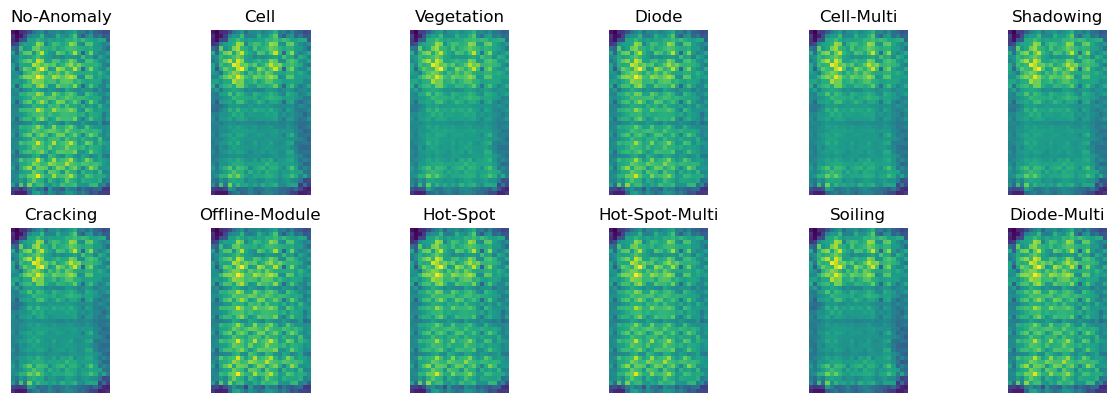

[Epoch 11/200] [D loss: 0.6832002311944961] [G loss: 0.749716454744339]
[Epoch 12/200] [D loss: 0.6849710446596146] [G loss: 0.8183732622861862]
[Epoch 13/200] [D loss: 0.6828317856788635] [G loss: 0.8215805006027221]
[Epoch 14/200] [D loss: 0.6382698091864586] [G loss: 0.9615707659721374]
[Epoch 15/200] [D loss: 0.6867443877458572] [G loss: 0.8355740362405777]
[Epoch 16/200] [D loss: 0.6780799823999405] [G loss: 0.919050948023796]
[Epoch 17/200] [D loss: 0.6727576506137848] [G loss: 0.8377154958248139]
[Epoch 18/200] [D loss: 0.6549494251608848] [G loss: 0.9430616170167923]
[Epoch 19/200] [D loss: 0.6409349942207336] [G loss: 0.9290364581346512]
[Epoch 20/200] [D loss: 0.6561762210726738] [G loss: 0.9800764381885528]


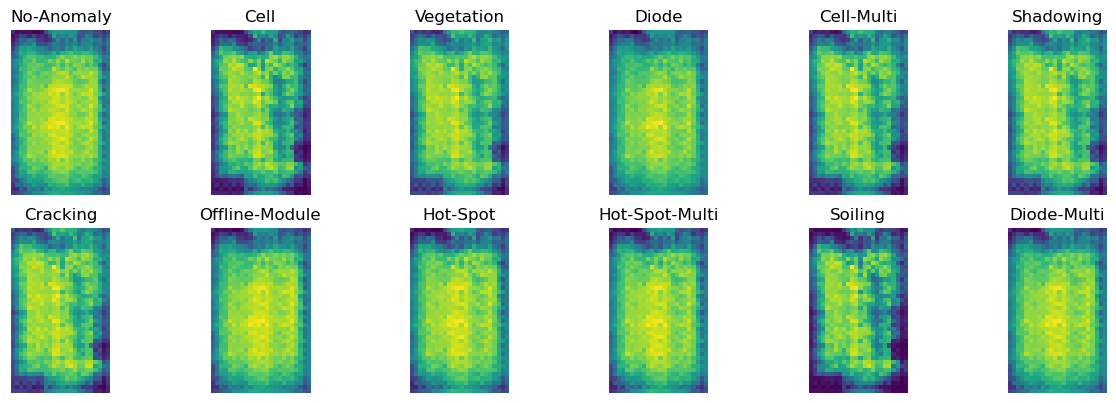

[Epoch 21/200] [D loss: 0.6403076806664467] [G loss: 1.119802633523941]
[Epoch 22/200] [D loss: 0.6033548191189766] [G loss: 1.0557103729248047]
[Epoch 23/200] [D loss: 0.6695665749907493] [G loss: 0.9662579190731049]
[Epoch 24/200] [D loss: 0.6645135155320168] [G loss: 0.9472327387332916]
[Epoch 25/200] [D loss: 0.6255630430579185] [G loss: 1.0988321721553802]
[Epoch 26/200] [D loss: 0.6121003526449204] [G loss: 1.1140075302124024]
[Epoch 27/200] [D loss: 0.631592969596386] [G loss: 1.0573446387052536]
[Epoch 28/200] [D loss: 0.6366733530163765] [G loss: 1.0283083355426788]
[Epoch 29/200] [D loss: 0.5981201419979334] [G loss: 1.3829862052202224]
[Epoch 30/200] [D loss: 0.5553719331324101] [G loss: 1.2975399553775788]


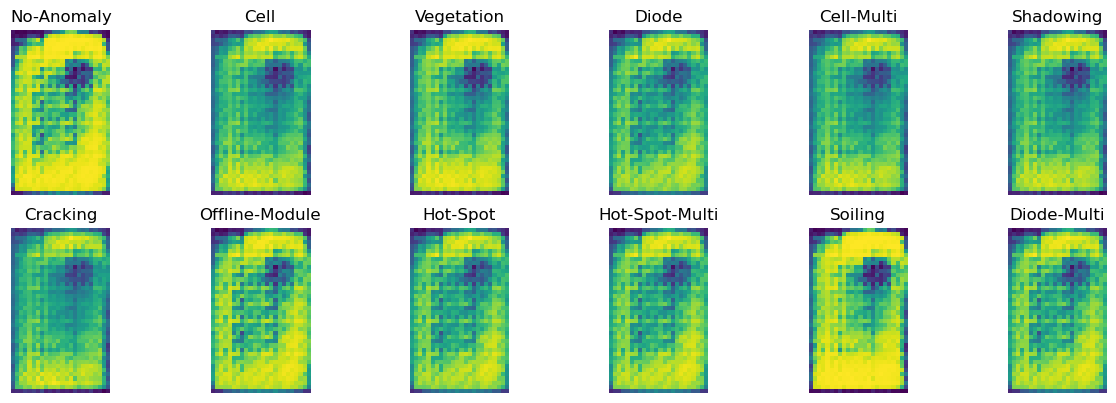

[Epoch 31/200] [D loss: 0.6235201528668404] [G loss: 1.1206560176610947]
[Epoch 32/200] [D loss: 0.5572098399698734] [G loss: 1.3321516925096513]
[Epoch 33/200] [D loss: 0.5585892051458359] [G loss: 1.4886751055717469]
[Epoch 34/200] [D loss: 0.5651423838734627] [G loss: 1.5015718060731889]
[Epoch 35/200] [D loss: 0.5717542940378189] [G loss: 1.1839634627103806]
[Epoch 36/200] [D loss: 0.5497136512398719] [G loss: 1.4931959575414657]
[Epoch 37/200] [D loss: 0.5860163515806198] [G loss: 1.173452953696251]
[Epoch 38/200] [D loss: 0.5769752605259418] [G loss: 1.4525253707170487]
[Epoch 39/200] [D loss: 0.6038752488791943] [G loss: 1.2886995768547058]
[Epoch 40/200] [D loss: 0.5551541922986507] [G loss: 1.3717180263996125]


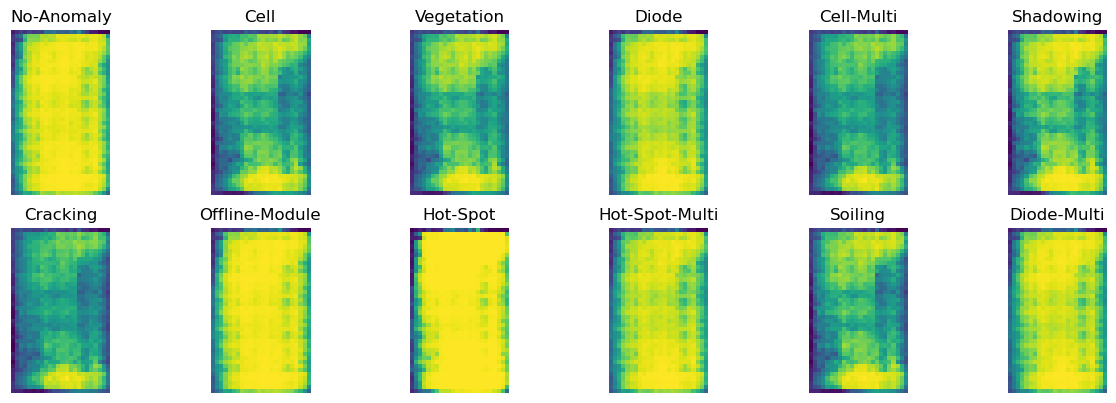

[Epoch 41/200] [D loss: 0.5970315629243851] [G loss: 1.3721768456697463]
[Epoch 42/200] [D loss: 0.5589104336500168] [G loss: 1.258708854317665]
[Epoch 43/200] [D loss: 0.5234048548340797] [G loss: 1.5655845290422439]
[Epoch 44/200] [D loss: 0.5552960014343262] [G loss: 1.3466826963424683]
[Epoch 45/200] [D loss: 0.5785304135084153] [G loss: 1.2637931090593337]
[Epoch 46/200] [D loss: 0.6296578267216683] [G loss: 1.121275435090065]
[Epoch 47/200] [D loss: 0.6409321400523186] [G loss: 0.9933300310373306]
[Epoch 48/200] [D loss: 0.6785254716873169] [G loss: 0.8463873201608658]
[Epoch 49/200] [D loss: 0.6841149997711181] [G loss: 0.7780604273080826]
[Epoch 50/200] [D loss: 0.6715394568443298] [G loss: 0.7475540322065354]


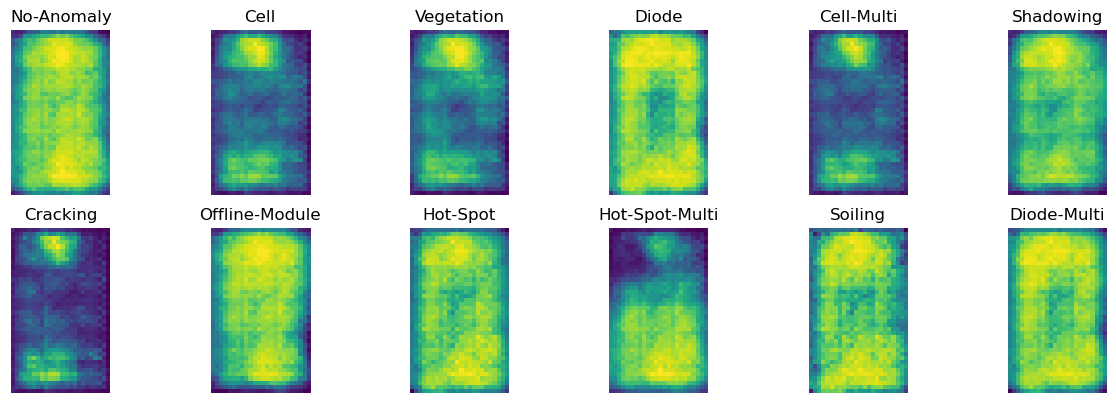

[Epoch 51/200] [D loss: 0.6760286444425583] [G loss: 0.7456100142002106]
[Epoch 52/200] [D loss: 0.6763278788328171] [G loss: 0.7782101720571518]
[Epoch 53/200] [D loss: 0.6747855252027511] [G loss: 0.780475236773491]
[Epoch 54/200] [D loss: 0.6827693444490432] [G loss: 0.7630055332183838]
[Epoch 55/200] [D loss: 0.6722462892532348] [G loss: 0.7637376004457473]
[Epoch 56/200] [D loss: 0.6704146009683609] [G loss: 0.7564898985624313]
[Epoch 57/200] [D loss: 0.6642271369695664] [G loss: 0.7800599926710129]
[Epoch 58/200] [D loss: 0.6583825016021728] [G loss: 0.817350292801857]
[Epoch 59/200] [D loss: 0.6879988783597946] [G loss: 0.7799408918619156]
[Epoch 60/200] [D loss: 0.6726767653226853] [G loss: 0.7562327611446381]


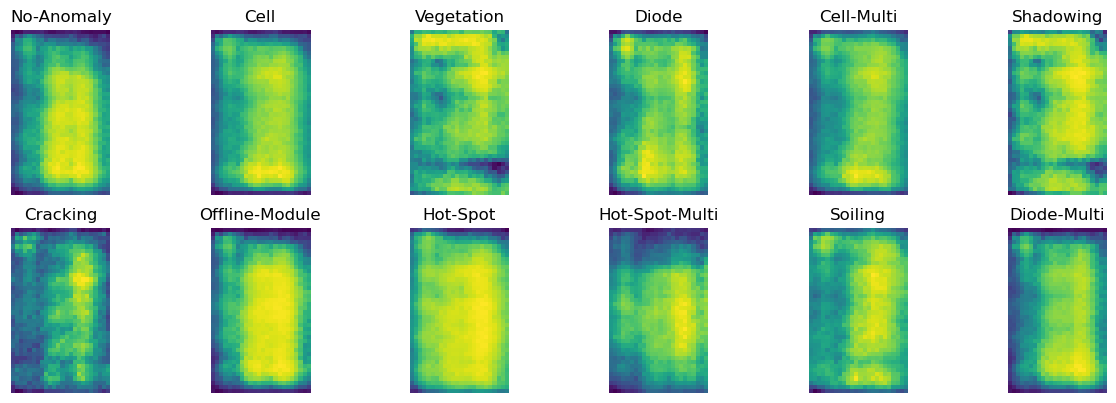

[Epoch 61/200] [D loss: 0.6764683562517166] [G loss: 0.7509413903951645]
[Epoch 62/200] [D loss: 0.6675437664985657] [G loss: 0.7630235236883164]
[Epoch 63/200] [D loss: 0.6838773548603058] [G loss: 0.7639108276367188]
[Epoch 64/200] [D loss: 0.6762563765048981] [G loss: 0.7422962576150894]
[Epoch 65/200] [D loss: 0.6799755662679672] [G loss: 0.7520947998762131]
[Epoch 66/200] [D loss: 0.6761446541547775] [G loss: 0.755372154712677]
[Epoch 67/200] [D loss: 0.6845314174890518] [G loss: 0.7530995935201645]
[Epoch 68/200] [D loss: 0.6892149144411087] [G loss: 0.7726685506105423]
[Epoch 69/200] [D loss: 0.6849995452165604] [G loss: 0.7298050117492676]
[Epoch 70/200] [D loss: 0.674161479473114] [G loss: 0.7417249637842178]


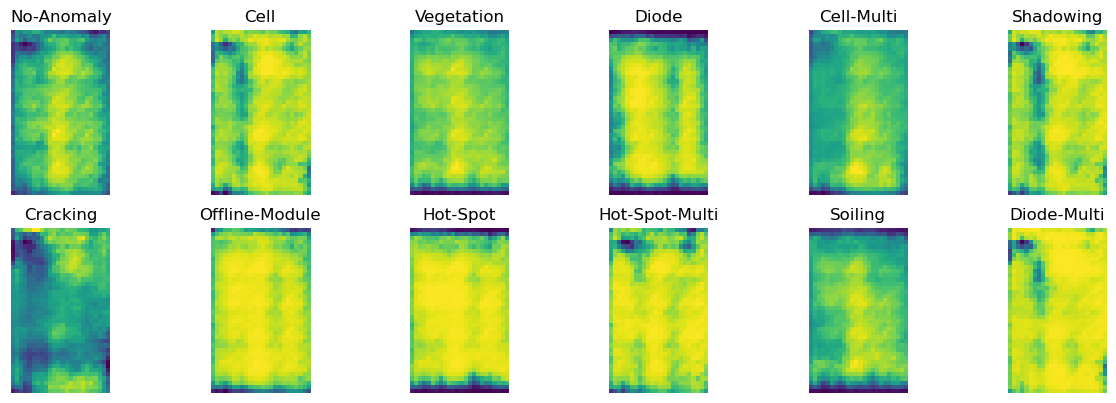

[Epoch 71/200] [D loss: 0.676142206788063] [G loss: 0.7551427257061004]
[Epoch 72/200] [D loss: 0.6860355114936829] [G loss: 0.765125572681427]
[Epoch 73/200] [D loss: 0.6764032459259033] [G loss: 0.7466465085744858]
[Epoch 74/200] [D loss: 0.6720355844497681] [G loss: 0.7662732863426208]
[Epoch 75/200] [D loss: 0.6851445871591568] [G loss: 0.7776291096210479]
[Epoch 76/200] [D loss: 0.6879652100801468] [G loss: 0.762690299153328]
[Epoch 77/200] [D loss: 0.6695599019527435] [G loss: 0.7559024125337601]
[Epoch 78/200] [D loss: 0.6837634813785552] [G loss: 0.753919740319252]
[Epoch 79/200] [D loss: 0.6717307901382447] [G loss: 0.7586217856407166]
[Epoch 80/200] [D loss: 0.6884087771177292] [G loss: 0.7817876678705216]


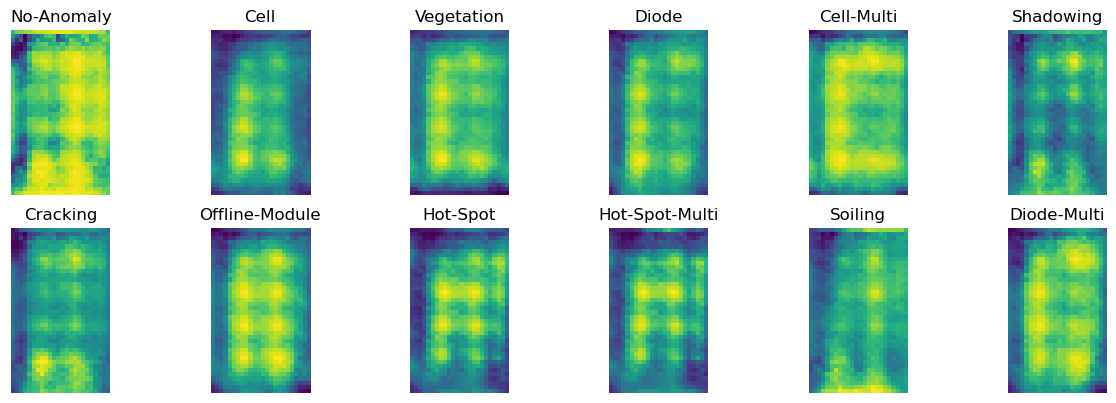

[Epoch 81/200] [D loss: 0.678862914443016] [G loss: 0.7746994429826737]
[Epoch 82/200] [D loss: 0.6664670228958129] [G loss: 0.7569478172063827]
[Epoch 83/200] [D loss: 0.6786372178792953] [G loss: 0.7782910871505737]
[Epoch 84/200] [D loss: 0.6821626722812653] [G loss: 0.7617358714342117]
[Epoch 85/200] [D loss: 0.6651692992448807] [G loss: 0.7843204337358475]
[Epoch 86/200] [D loss: 0.6736306315660476] [G loss: 0.7923776984214783]
[Epoch 87/200] [D loss: 0.6857088702917099] [G loss: 0.7830741059780121]
[Epoch 88/200] [D loss: 0.6809828859567643] [G loss: 0.7875898069143296]
[Epoch 89/200] [D loss: 0.6817834901809693] [G loss: 0.7608547288179398]
[Epoch 90/200] [D loss: 0.6719610971212387] [G loss: 0.7576653134822845]


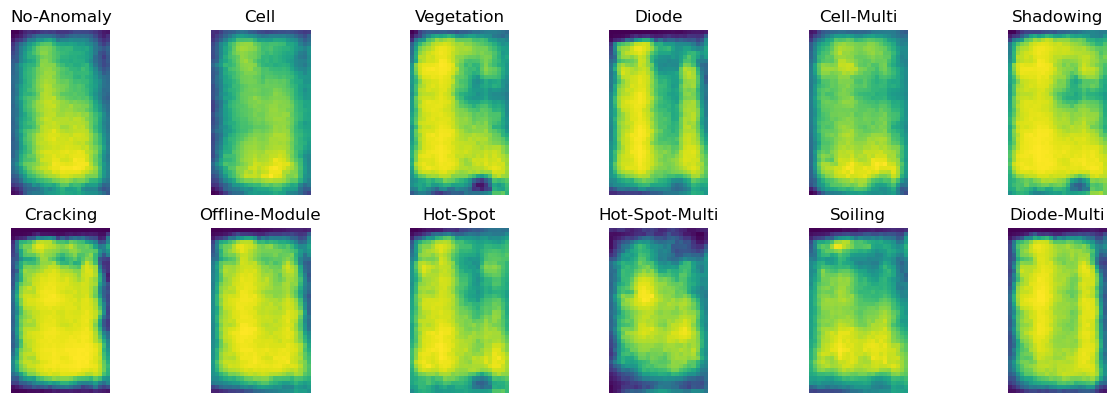

[Epoch 91/200] [D loss: 0.6816093456745148] [G loss: 0.7703365218639374]
[Epoch 92/200] [D loss: 0.6765798938274383] [G loss: 0.7420394563674927]
[Epoch 93/200] [D loss: 0.6762280195951462] [G loss: 0.7651084977388382]
[Epoch 94/200] [D loss: 0.6765195167064667] [G loss: 0.7569237357378006]
[Epoch 95/200] [D loss: 0.6830198985338211] [G loss: 0.7443670588731766]
[Epoch 96/200] [D loss: 0.6793088620901108] [G loss: 0.7434882700443268]
[Epoch 97/200] [D loss: 0.6816560858488083] [G loss: 0.761639769077301]
[Epoch 98/200] [D loss: 0.6845333987474441] [G loss: 0.7405194085836411]
[Epoch 99/200] [D loss: 0.6888905847072602] [G loss: 0.7431169188022614]
[Epoch 100/200] [D loss: 0.6806067800521851] [G loss: 0.7481583392620087]


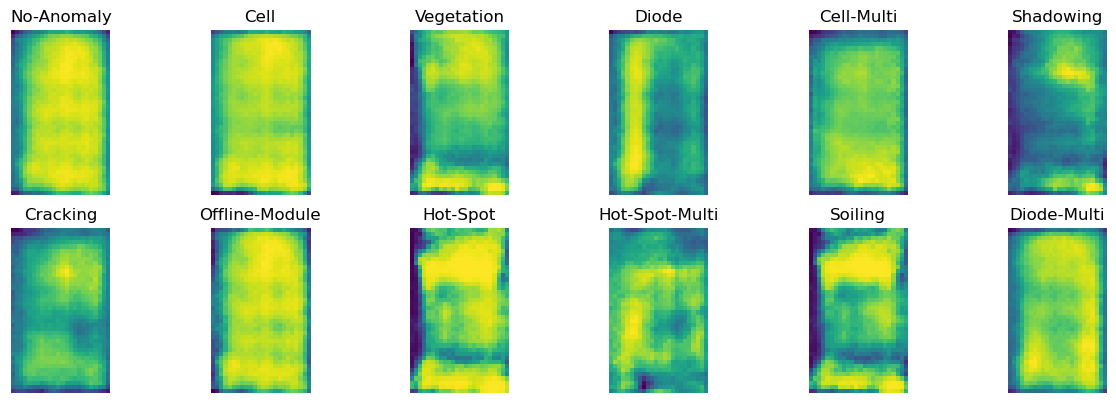

[Epoch 101/200] [D loss: 0.684111790060997] [G loss: 0.7412854039669037]
[Epoch 102/200] [D loss: 0.6805934250354767] [G loss: 0.7446078407764435]
[Epoch 103/200] [D loss: 0.6803440976142884] [G loss: 0.7477327287197113]
[Epoch 104/200] [D loss: 0.6797421884536743] [G loss: 0.7439987725019455]
[Epoch 105/200] [D loss: 0.6872265356779098] [G loss: 0.7654295510053635]
[Epoch 106/200] [D loss: 0.6859162455797195] [G loss: 0.7425988554954529]
[Epoch 107/200] [D loss: 0.6804589354991912] [G loss: 0.7349898672103882]
[Epoch 108/200] [D loss: 0.6819062834978104] [G loss: 0.7314142769575119]
[Epoch 109/200] [D loss: 0.6835918414592743] [G loss: 0.7401010119915008]
[Epoch 110/200] [D loss: 0.6851522296667099] [G loss: 0.7476978665590286]


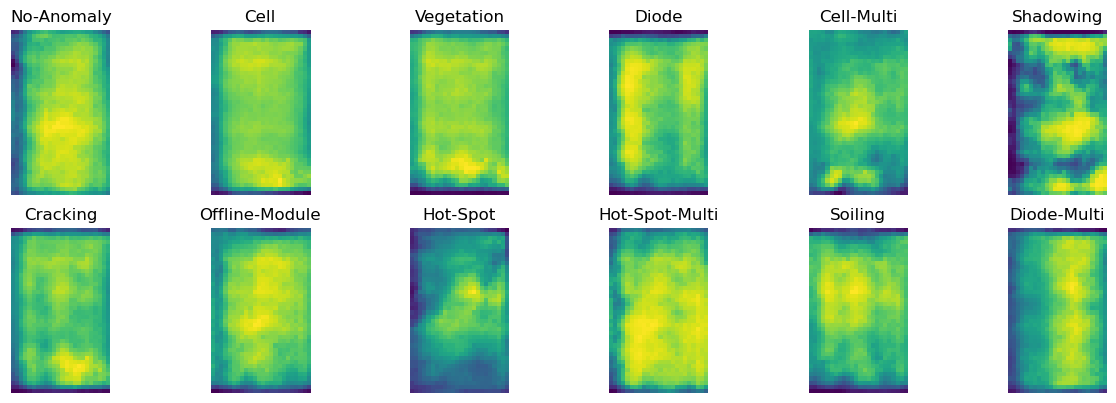

[Epoch 111/200] [D loss: 0.6835885888338089] [G loss: 0.7425101894140244]
[Epoch 112/200] [D loss: 0.6903304624557495] [G loss: 0.7564254105091095]
[Epoch 113/200] [D loss: 0.684302243590355] [G loss: 0.7265270757675171]
[Epoch 114/200] [D loss: 0.6822549223899841] [G loss: 0.7270578300952911]
[Epoch 115/200] [D loss: 0.6827764934301377] [G loss: 0.7428538537025452]
[Epoch 116/200] [D loss: 0.6893153983354569] [G loss: 0.7537125384807587]
[Epoch 117/200] [D loss: 0.6895821011066436] [G loss: 0.727709646821022]
[Epoch 118/200] [D loss: 0.6871902239322663] [G loss: 0.7304813784360885]
[Epoch 119/200] [D loss: 0.6852777147293091] [G loss: 0.7286491549015045]
[Epoch 120/200] [D loss: 0.687092456817627] [G loss: 0.7197554552555084]


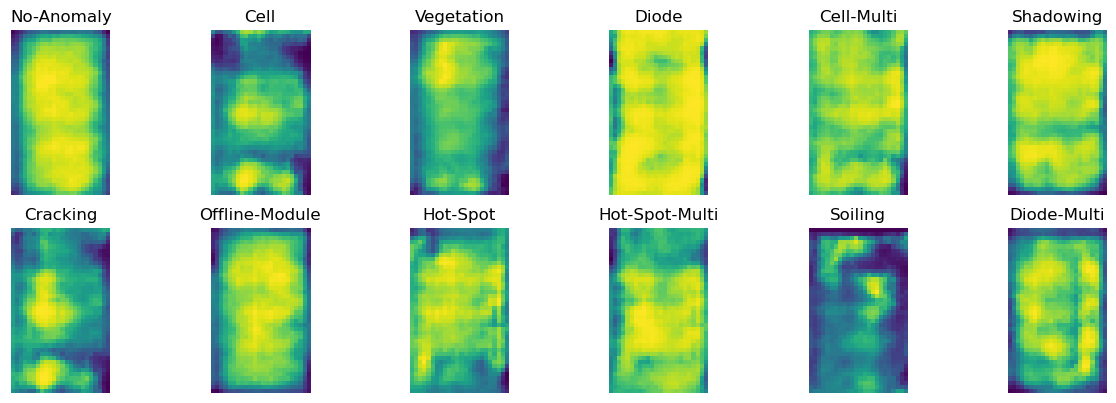

[Epoch 121/200] [D loss: 0.6845959287881851] [G loss: 0.7254229509830474]
[Epoch 122/200] [D loss: 0.685677656531334] [G loss: 0.731901741027832]
[Epoch 123/200] [D loss: 0.6889621895551682] [G loss: 0.7394803088903427]
[Epoch 124/200] [D loss: 0.6876756846904755] [G loss: 0.7319048947095871]
[Epoch 125/200] [D loss: 0.6818469846248627] [G loss: 0.7351176476478577]
[Epoch 126/200] [D loss: 0.6903151798248292] [G loss: 0.7337453919649124]
[Epoch 127/200] [D loss: 0.6908363562822342] [G loss: 0.7258597791194916]
[Epoch 128/200] [D loss: 0.6809081095457077] [G loss: 0.7280542695522308]
[Epoch 129/200] [D loss: 0.6758261841535568] [G loss: 0.7360364735126496]
[Epoch 130/200] [D loss: 0.6967766058444976] [G loss: 0.7223804897069931]


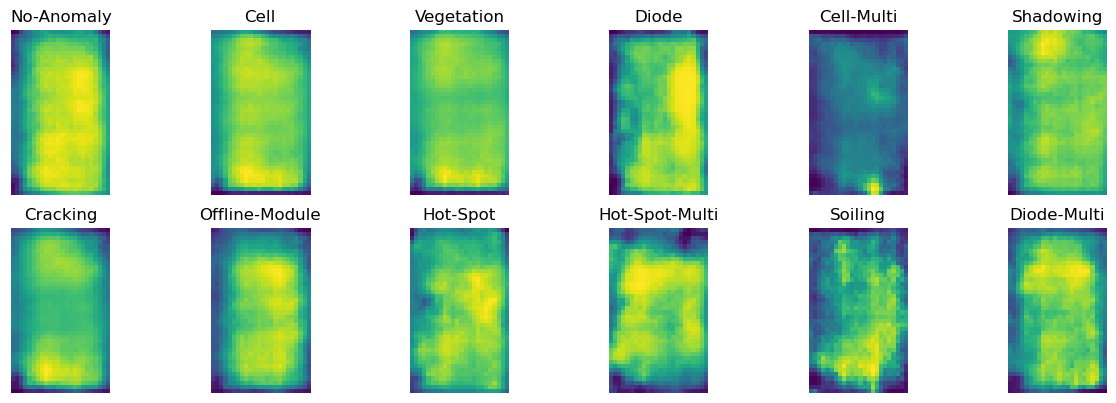

[Epoch 131/200] [D loss: 0.6850698012113571] [G loss: 0.7195873177051544]
[Epoch 132/200] [D loss: 0.68708192050457] [G loss: 0.7163132971525192]
[Epoch 133/200] [D loss: 0.6852397072315216] [G loss: 0.7334820765256882]
[Epoch 134/200] [D loss: 0.688754130601883] [G loss: 0.7289550983905793]
[Epoch 135/200] [D loss: 0.6843296712636948] [G loss: 0.7244085639715194]
[Epoch 136/200] [D loss: 0.6847761404514313] [G loss: 0.7254088294506073]
[Epoch 137/200] [D loss: 0.6920137166976928] [G loss: 0.7227922528982162]
[Epoch 138/200] [D loss: 0.6846112591028214] [G loss: 0.7161622357368469]
[Epoch 139/200] [D loss: 0.6839061516523361] [G loss: 0.7187995010614395]
[Epoch 140/200] [D loss: 0.6853549808263779] [G loss: 0.7175333446264267]


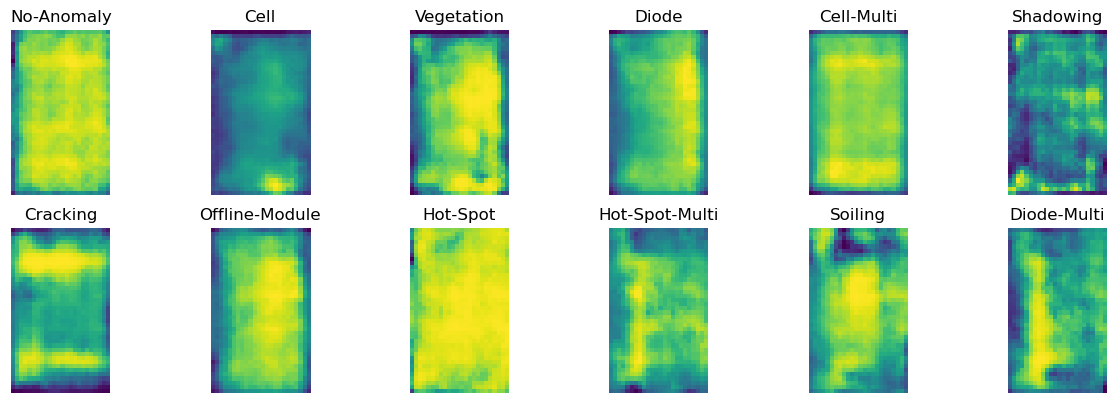

[Epoch 141/200] [D loss: 0.682762633562088] [G loss: 0.7177698135375976]
[Epoch 142/200] [D loss: 0.6873234993219376] [G loss: 0.714316359758377]
[Epoch 143/200] [D loss: 0.6846860671043395] [G loss: 0.7164349853992462]
[Epoch 144/200] [D loss: 0.6880123919248581] [G loss: 0.718401757478714]
[Epoch 145/200] [D loss: 0.6839805650711059] [G loss: 0.7123462545871735]
[Epoch 146/200] [D loss: 0.6847340881824493] [G loss: 0.7161295026540756]
[Epoch 147/200] [D loss: 0.688700001835823] [G loss: 0.726340069770813]
[Epoch 148/200] [D loss: 0.6912541788816452] [G loss: 0.7186236137151718]
[Epoch 149/200] [D loss: 0.6883964216709137] [G loss: 0.7115442550182343]
[Epoch 150/200] [D loss: 0.692257114648819] [G loss: 0.7113836789131165]


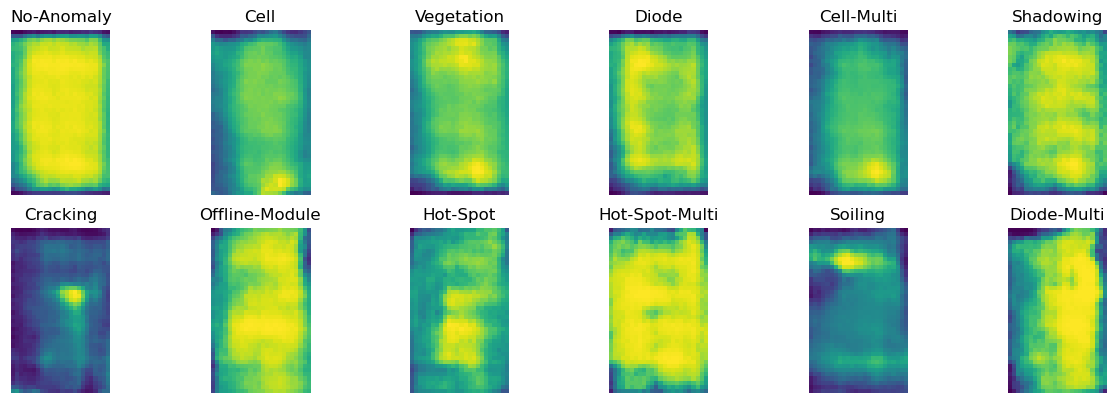

[Epoch 151/200] [D loss: 0.6891268247365951] [G loss: 0.7134882020950317]
[Epoch 152/200] [D loss: 0.6893885552883148] [G loss: 0.7140499323606491]
[Epoch 153/200] [D loss: 0.6900077128410339] [G loss: 0.7112686759233475]
[Epoch 154/200] [D loss: 0.6895315980911255] [G loss: 0.7075699901580811]
[Epoch 155/200] [D loss: 0.6906290864944458] [G loss: 0.7075538724660874]
[Epoch 156/200] [D loss: 0.6873785763978958] [G loss: 0.706749736070633]
[Epoch 157/200] [D loss: 0.6878610229492188] [G loss: 0.7031538313627244]
[Epoch 158/200] [D loss: 0.6886960333585739] [G loss: 0.7187564420700073]
[Epoch 159/200] [D loss: 0.6900086152553558] [G loss: 0.7028434997797013]
[Epoch 160/200] [D loss: 0.6887638455629349] [G loss: 0.7082735937833786]


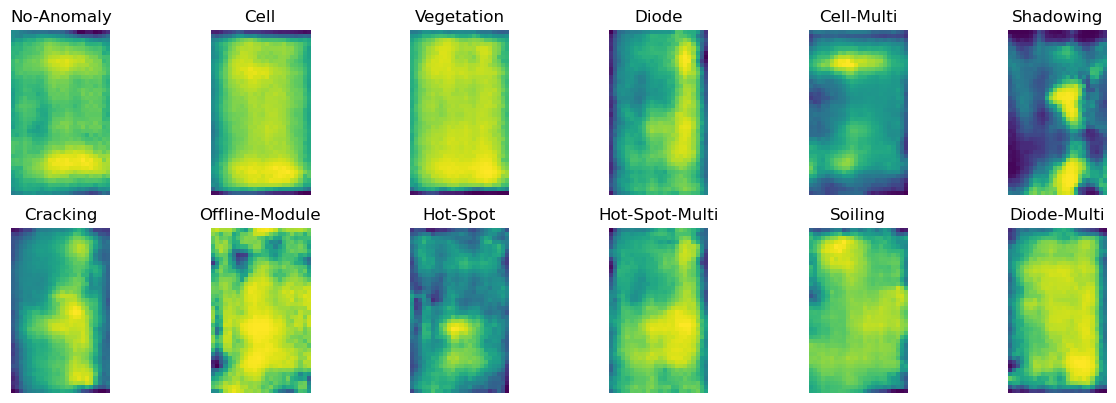

[Epoch 161/200] [D loss: 0.687416005730629] [G loss: 0.7065966594219207]
[Epoch 162/200] [D loss: 0.689871192574501] [G loss: 0.7055707794427871]
[Epoch 163/200] [D loss: 0.6942483007907867] [G loss: 0.7038556575775147]
[Epoch 164/200] [D loss: 0.6894257801771164] [G loss: 0.7018117660284042]
[Epoch 165/200] [D loss: 0.6912641936540603] [G loss: 0.7092717784643173]
[Epoch 166/200] [D loss: 0.6901877647638321] [G loss: 0.7072975790500641]
[Epoch 167/200] [D loss: 0.6921656227111816] [G loss: 0.7040508031845093]
[Epoch 168/200] [D loss: 0.6885540401935577] [G loss: 0.7077716386318207]
[Epoch 169/200] [D loss: 0.6914879941940307] [G loss: 0.7068398535251618]
[Epoch 170/200] [D loss: 0.6923230546712875] [G loss: 0.7086346572637559]


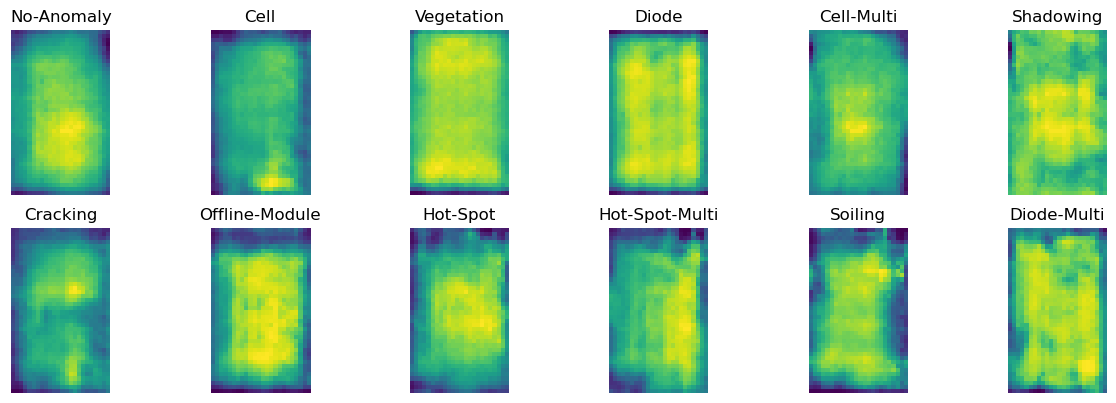

[Epoch 171/200] [D loss: 0.6908901816606522] [G loss: 0.698451589345932]
[Epoch 172/200] [D loss: 0.693590145111084] [G loss: 0.7060944563150406]
[Epoch 173/200] [D loss: 0.6907376962900161] [G loss: 0.7061618793010712]
[Epoch 174/200] [D loss: 0.6911117064952851] [G loss: 0.704381148815155]
[Epoch 175/200] [D loss: 0.6890870851278305] [G loss: 0.7036240428686142]
[Epoch 176/200] [D loss: 0.6899080836772918] [G loss: 0.7045004171133041]
[Epoch 177/200] [D loss: 0.6915935724973679] [G loss: 0.7002208805084229]
[Epoch 178/200] [D loss: 0.6916588491201401] [G loss: 0.700506848692894]
[Epoch 179/200] [D loss: 0.6904951930046082] [G loss: 0.7027202016115188]
[Epoch 180/200] [D loss: 0.6917223787307739] [G loss: 0.7005822628736496]


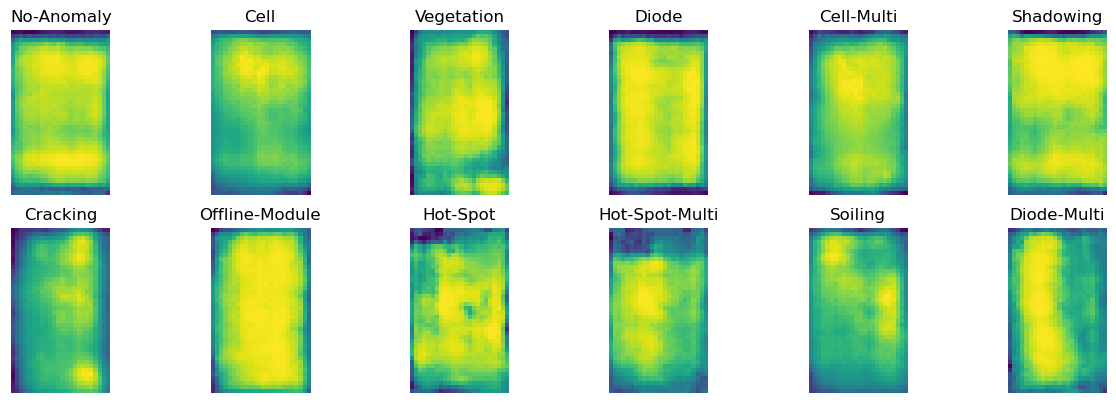

[Epoch 181/200] [D loss: 0.6889465659856796] [G loss: 0.7043298929929733]
[Epoch 182/200] [D loss: 0.6909728878736496] [G loss: 0.7038768196105957]
[Epoch 183/200] [D loss: 0.692108525633812] [G loss: 0.7003956490755081]
[Epoch 184/200] [D loss: 0.6921789276599885] [G loss: 0.6991112011671067]
[Epoch 185/200] [D loss: 0.6915434938669205] [G loss: 0.7077993303537369]
[Epoch 186/200] [D loss: 0.6926934152841568] [G loss: 0.7027181231975556]
[Epoch 187/200] [D loss: 0.6896806532144546] [G loss: 0.6973295378684997]
[Epoch 188/200] [D loss: 0.6942480725049972] [G loss: 0.6977107459306717]
[Epoch 189/200] [D loss: 0.6936777722835541] [G loss: 0.6997432827949523]
[Epoch 190/200] [D loss: 0.6924958086013794] [G loss: 0.7013457781076431]


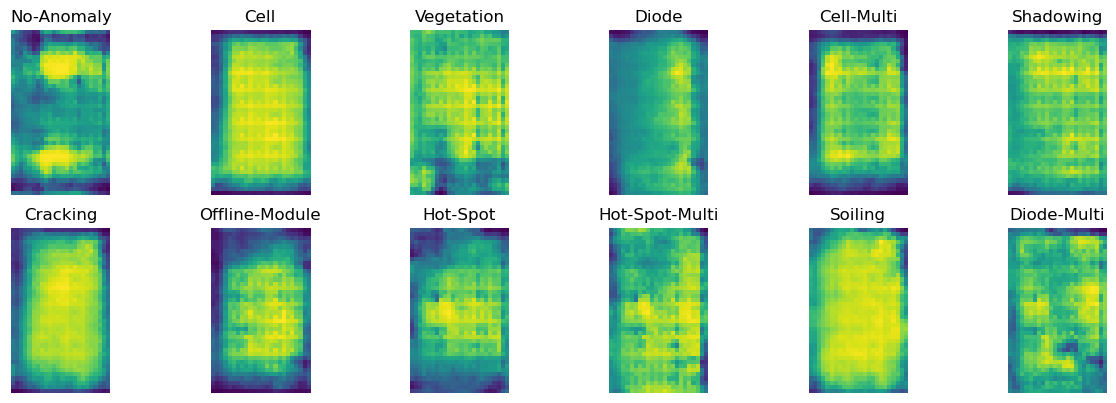

[Epoch 191/200] [D loss: 0.6925834095478058] [G loss: 0.7116280400753021]
[Epoch 192/200] [D loss: 0.6917812001705169] [G loss: 0.7007056725025177]
[Epoch 193/200] [D loss: 0.691543642282486] [G loss: 0.7015681475400924]
[Epoch 194/200] [D loss: 0.6923022949695588] [G loss: 0.7055624741315841]
[Epoch 195/200] [D loss: 0.6902340996265411] [G loss: 0.6986741787195205]
[Epoch 196/200] [D loss: 0.689759429693222] [G loss: 0.6970301049947739]
[Epoch 197/200] [D loss: 0.6910098379850388] [G loss: 0.700513687133789]
[Epoch 198/200] [D loss: 0.6904967415332794] [G loss: 0.6964286410808563]
[Epoch 199/200] [D loss: 0.6915255796909332] [G loss: 0.70063323199749]


In [298]:
fit_total_loss_gen, fit_total_loss_disc = g_model.fit(g_train_test.train_dataloader, epochs=200)

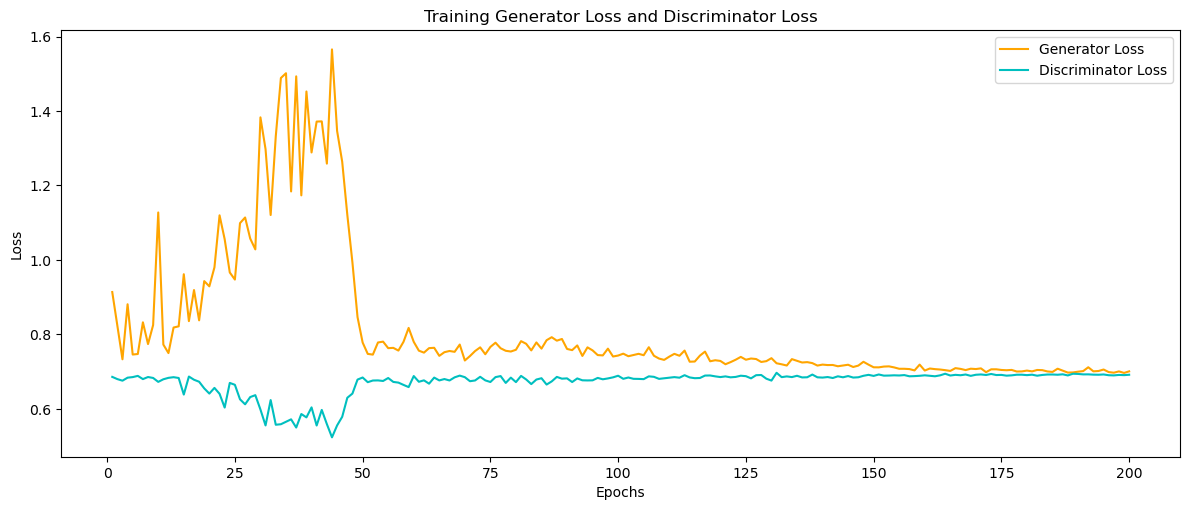

In [299]:
# Plot the loss and accuracy curves
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

axs.plot(range(1, len(fit_total_loss_gen) + 1), fit_total_loss_gen, color='orange', label="Generator Loss")
axs.plot(range(1, len(fit_total_loss_disc) + 1), fit_total_loss_disc, color='c', label="Discriminator Loss")
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()

plt.tight_layout()  # ensure the two axes are on the same scale
plt.title('Training Generator Loss and Discriminator Loss')
plt.show()

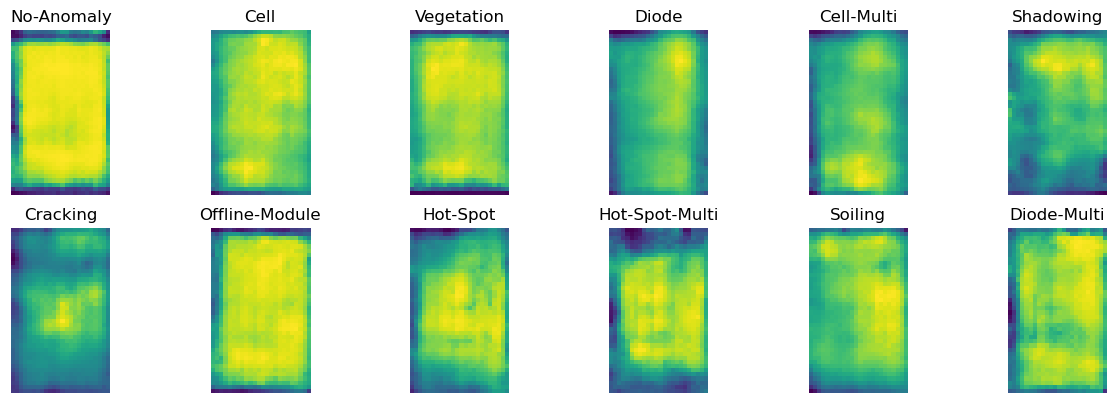

In [373]:
plt.figure(figsize=(15,15))
for j in range(solar_dataset.num_classes):
    image = g_model.augment(1, j)[0].cpu().numpy()
    plt.subplot(6, 6, j+1)
    plt.imshow((image.transpose(1, 2, 0) + 1.0) / 2.0)
    plt.title(solar_dataset.classes_list[j])
    plt.axis('off')
plt.show()

In [412]:
def preprocess_gan_agument(image, aug_number, label):
    image_list = []

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    image = (image - 127.5) / 127.5

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            transforms.ToTensor(),
        ])
    ]

    if aug_number == 0:
        image = image[np.newaxis]
        image_list.append(image)
    else:
        for _ in range(aug_number):
            if np.random.rand() <= 0.50:
                img_aug = g_model.augment(1, solar_dataset.classes_list.index(label))
                for im in img_aug:
                    image_list.append(im.cpu().numpy())
            else:
                image_list.append(transforms_list[0](Image.fromarray(image)).numpy())
    return image_list

In [413]:
input_dim = (1, 40, 24)
output_dim = solar_dataset.num_classes
our_model_gan = OurClassificator(input_dim, output_dim).to(device)
print(summary(our_model_gan, (1, input_dim[0], input_dim[1], input_dim[2])))
our_loss_gan = nn.BCEWithLogitsLoss().to(device)
our_optimizer_gan = Adam(our_model_gan.parameters(), lr=0.0003)
our_train_test_gan = utils.TrainTest(
    our_model_gan,
    our_loss_gan,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_gan_agument,
    augment=True,
)

Layer (type:depth-idx)                   Output Shape              Param #
OurClassificator                         [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Conv2d: 2-1                       [1, 60, 40, 24]           600
│    └─BatchNorm2d: 2-2                  [1, 60, 40, 24]           120
│    └─ReLU: 2-3                         [1, 60, 40, 24]           --
│    └─Dropout: 2-4                      [1, 60, 40, 24]           --
│    └─MaxPool2d: 2-5                    [1, 60, 20, 12]           --
│    └─Conv2d: 2-6                       [1, 120, 20, 12]          64,920
│    └─ReLU: 2-7                         [1, 120, 20, 12]          --
│    └─Dropout: 2-8                      [1, 120, 20, 12]          --
│    └─MaxPool2d: 2-9                    [1, 120, 10, 6]           --
│    └─Conv2d: 2-10                      [1, 240, 10, 6]           259,440
│    └─ReLU: 2-11                        [1, 240, 10, 6]           --
│   

Loss = 0.16094703901381718   Accuracy= 0.5920138888888888
Best Epoch # 0  Validation Loss= 0.16094703901381718  Validation Accu= 0.5920138888888888
Loss = 0.12657165329252917   Accuracy= 0.6999007936507936
Best Epoch # 1  Validation Loss= 0.12657165329252917  Validation Accu= 0.6999007936507936
Loss = 0.13297186513978337   Accuracy= 0.6877480158730159
Loss = 0.11479907553820383   Accuracy= 0.7562003968253969
Best Epoch # 3  Validation Loss= 0.11479907553820383  Validation Accu= 0.7562003968253969
Loss = 0.12623075933920014   Accuracy= 0.7534722222222222
Loss = 0.12957602422980088   Accuracy= 0.7554563492063492
Loss = 0.1324984553964838   Accuracy= 0.7703373015873016
Best Epoch # 6  Validation Loss= 0.1324984553964838  Validation Accu= 0.7703373015873016
Loss = 0.13674306553152818   Accuracy= 0.769593253968254
Loss = 0.14754017695252383   Accuracy= 0.7738095238095238
Best Epoch # 8  Validation Loss= 0.14754017695252383  Validation Accu= 0.7738095238095238
Loss = 0.16742676508332055   Ac

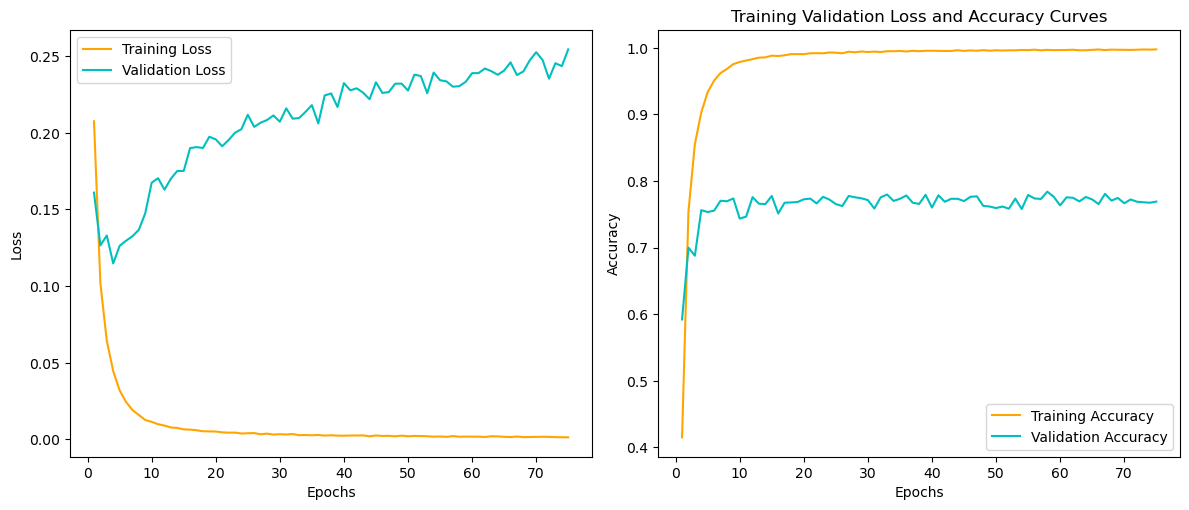

In [414]:
# Train Model
our_best_gan_loss, our_best_gan_accuracy, our_best_gan_epoch = our_train_test_gan.train(our_optimizer_gan, 75, "our_model_gan_aug.pth")

Loss = 0.6783516747610909   Accuracy= 0.7966269841269841


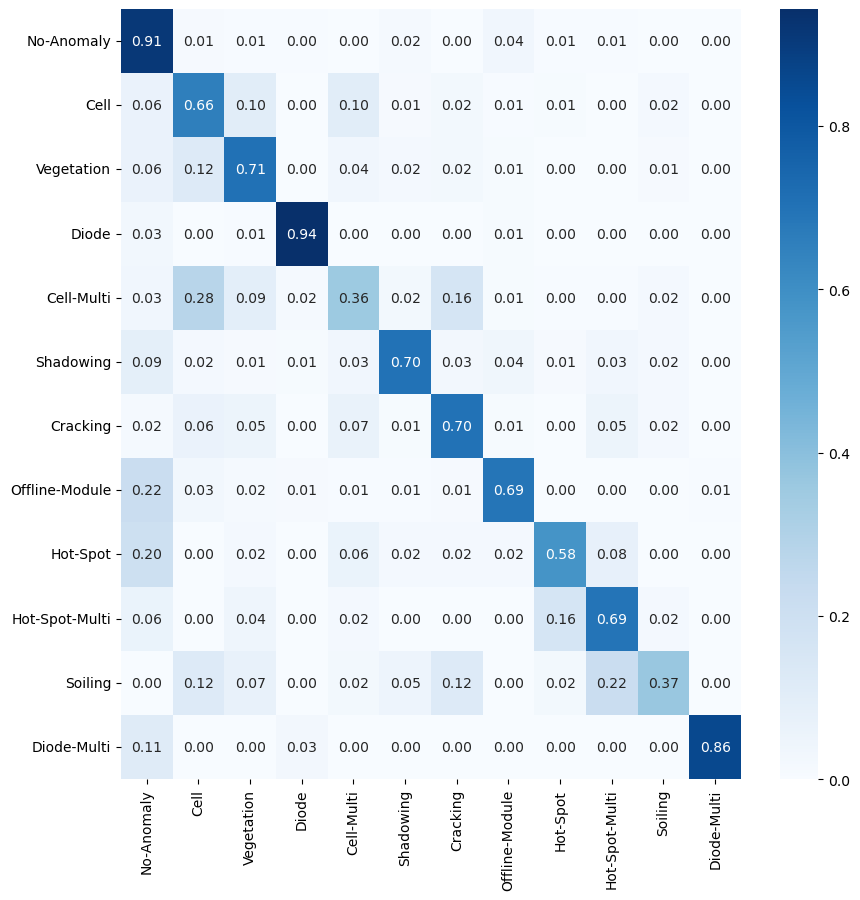

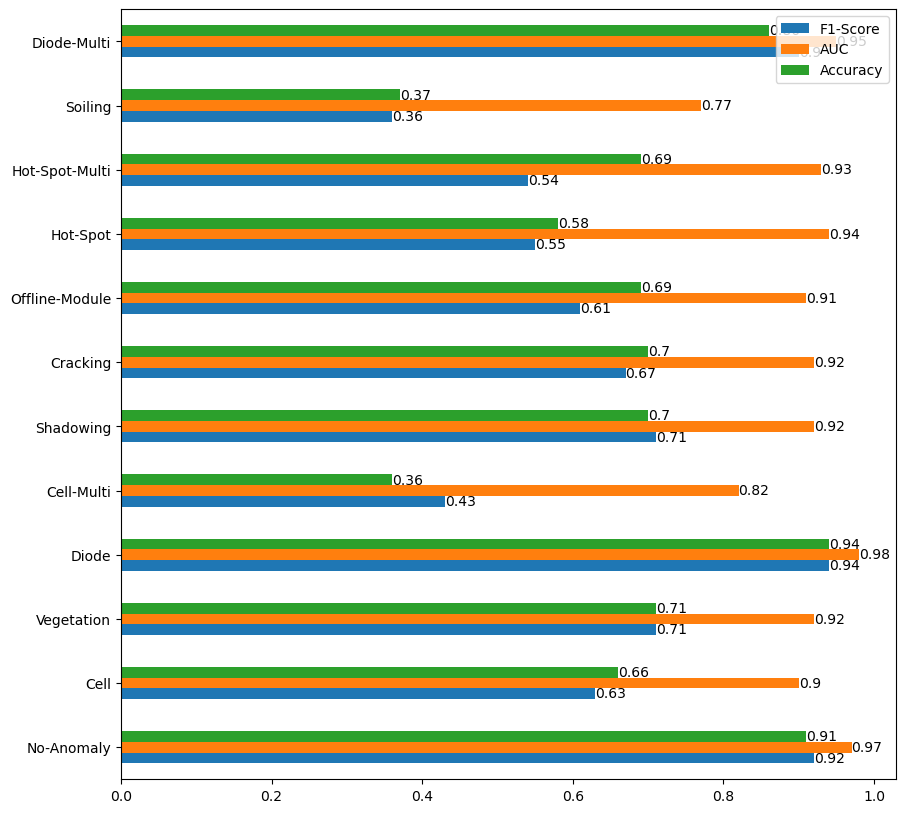

In [ ]:
our_train_test_gan.test()
our_train_test_gan.plot_confusion_matrix()
our_train_test_gan.plot_class_metrics()

---

# Pre-Trained Models

In computer vision, transfer learning is commonly used with convolutional neural networks (CNNs) pre-trained on large image datasets like ImageNet. These pre-trained models can be used as a fixed feature extractor for tasks such as object detection, image segmentation, and image classification.

After running our models we decided to use pre trained models:


*   MobileNet v2
*   Visual Transformers
<br><br>

The use of pre trained models in deep learning has some advantages such as:

**Reducing the training time** - since this models are already trained on large and diverse datasets like ImageNet they've learned rich feature representations.

**Less Labeled Data Required** -  they can perform well with smaller amounts of labeled data for the target task. This is crucial in scenarios where collecting large labeled datasets is time-consuming or expensive.

**Resource Savings**: Training deep neural networks from scratch requires significant computational resources. By using pre-trained models, we can save time, computing power, and energy consumption.

**Feature Retention through Freezing**: One of the key steps in transfer learning is the ability to freeze the layers of the pre-trained model so that only some portions of the network are updated during training. Freezing is crucial to maintain the features that the pre-trained model has already learned.

<br><br>

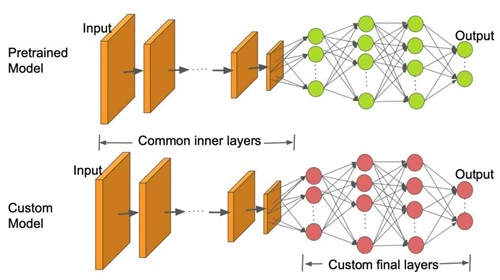

<br><br>

The image above ilustrates well one of the keys points for using pre-trained models in this project. The possibility of changeing the existing archisture of the model - we can freeze most of the parameters and use/change the others. Unfreezing a layer means that the weights and biases of that layer will be updated during the training process.



## MobileNetV2

In [214]:
def preprocess_mobile(image, aug_number=0, label=None):
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            #transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

In [215]:
input_dim = (3, 40, 24)

model_mobile = torchvision.models.mobilenet_v2(pretrained=True)
for i, param in enumerate(model_mobile.parameters()):
    param.requires_grad = False

num_features = model_mobile.classifier[1].in_features
model_mobile.classifier[1] = nn.Sequential(
    nn.Linear(num_features, 800),
    nn.ReLU(),
    nn.Dropout(0.50),
    nn.Linear(800, 500),
    nn.ReLU(),
    nn.Linear(500, 12),
)

print(summary(model_mobile.to(device), (1, input_dim[0], input_dim[1], input_dim[2])))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 12]                   --
├─Sequential: 1-1                                  [1, 1280, 2, 1]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 20, 12]           --
│    │    └─Conv2d: 3-1                            [1, 32, 20, 12]           (864)
│    │    └─BatchNorm2d: 3-2                       [1, 32, 20, 12]           (64)
│    │    └─ReLU6: 3-3                             [1, 32, 20, 12]           --
│    └─InvertedResidual: 2-2                       [1, 16, 20, 12]           --
│    │    └─Sequential: 3-4                        [1, 16, 20, 12]           (896)
│    └─InvertedResidual: 2-3                       [1, 24, 10, 6]            --
│    │    └─Sequential: 3-5                        [1, 24, 10, 6]            (5,136)
│    └─InvertedResidual: 2-4                       [1, 24, 10, 6]            --
│    │    └─Sequential

c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [216]:
loss_mobile = nn.BCEWithLogitsLoss().to(device)
optimizer_mobile = torch.optim.Adam(model_mobile.parameters(), lr=0.00025)
train_test_mobile = utils.TrainTest(
    model_mobile.to(device),
    loss_mobile,
    64,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_mobile,
    augment=False,
)

Loss = 0.20146672717399067   Accuracy= 0.5267857142857143
Best Epoch # 0  Validation Loss= 0.20146672717399067  Validation Accu= 0.5267857142857143
Loss = 0.18703640666272905   Accuracy= 0.5471230158730159
Best Epoch # 1  Validation Loss= 0.18703640666272905  Validation Accu= 0.5471230158730159
Loss = 0.18220784775321447   Accuracy= 0.5600198412698413
Best Epoch # 2  Validation Loss= 0.18220784775321447  Validation Accu= 0.5600198412698413
Loss = 0.1793098556143897   Accuracy= 0.5677083333333334
Best Epoch # 3  Validation Loss= 0.1793098556143897  Validation Accu= 0.5677083333333334
Loss = 0.17672560038784194   Accuracy= 0.5714285714285714
Best Epoch # 4  Validation Loss= 0.17672560038784194  Validation Accu= 0.5714285714285714
Loss = 0.17578009521913907   Accuracy= 0.574156746031746
Best Epoch # 5  Validation Loss= 0.17578009521913907  Validation Accu= 0.574156746031746
Loss = 0.17226305846420545   Accuracy= 0.5798611111111112
Best Epoch # 6  Validation Loss= 0.17226305846420545  Vali

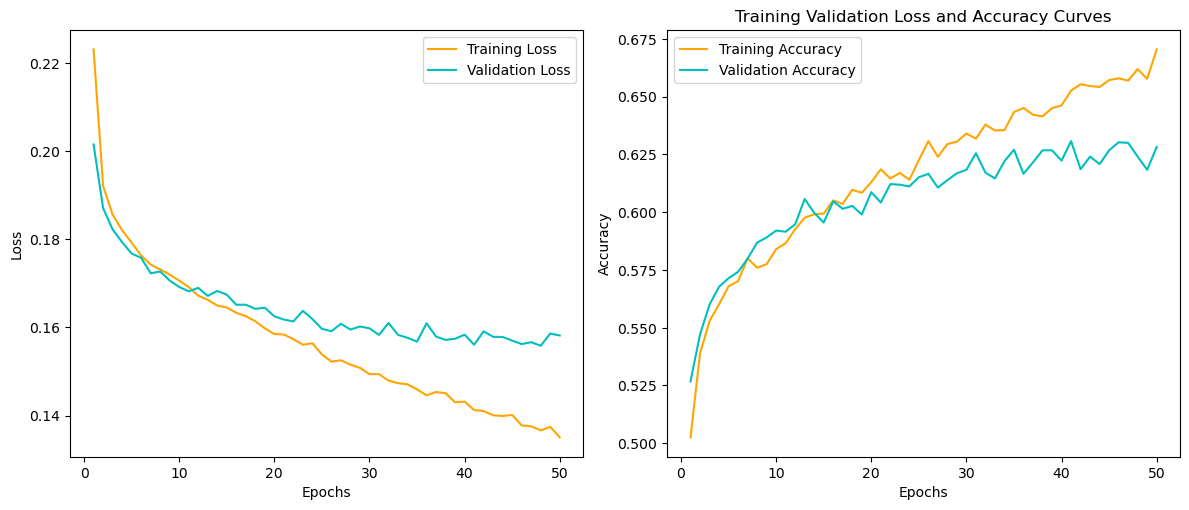

In [217]:
# Train Model
our_best_mobile_loss, our_best_mobile_accuracy, our_best_mobile_epoch = train_test_mobile.train(optimizer_mobile, 50, "mobile_model.pth")

Loss = 0.15815746636381225   Accuracy= 0.6282242063492064


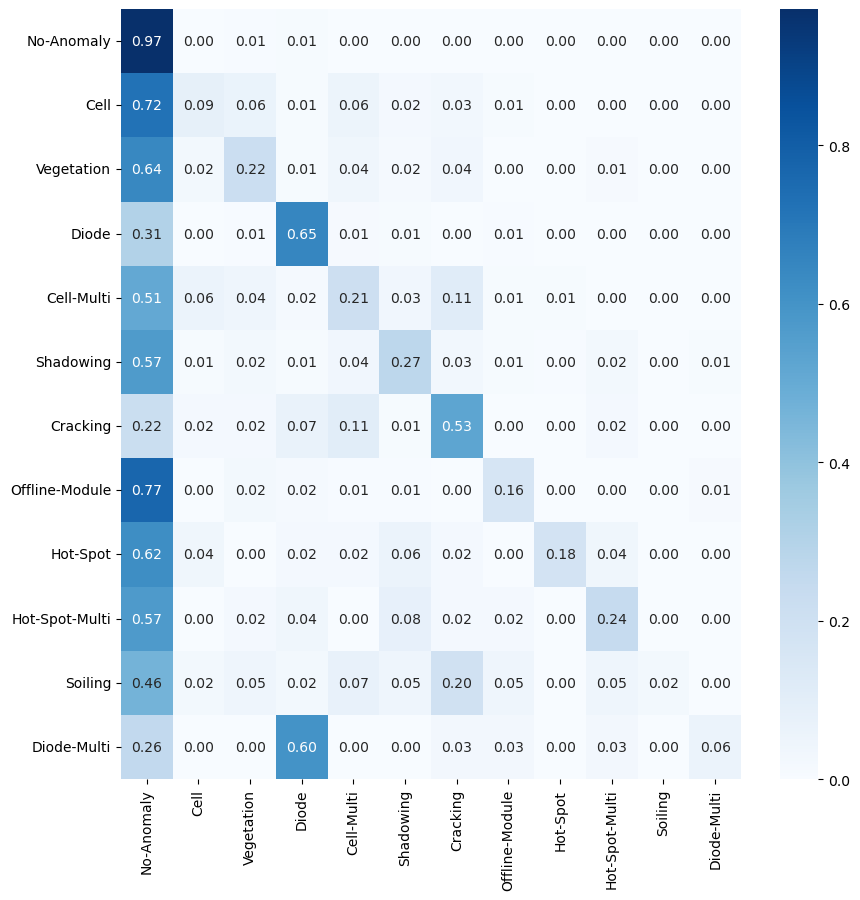

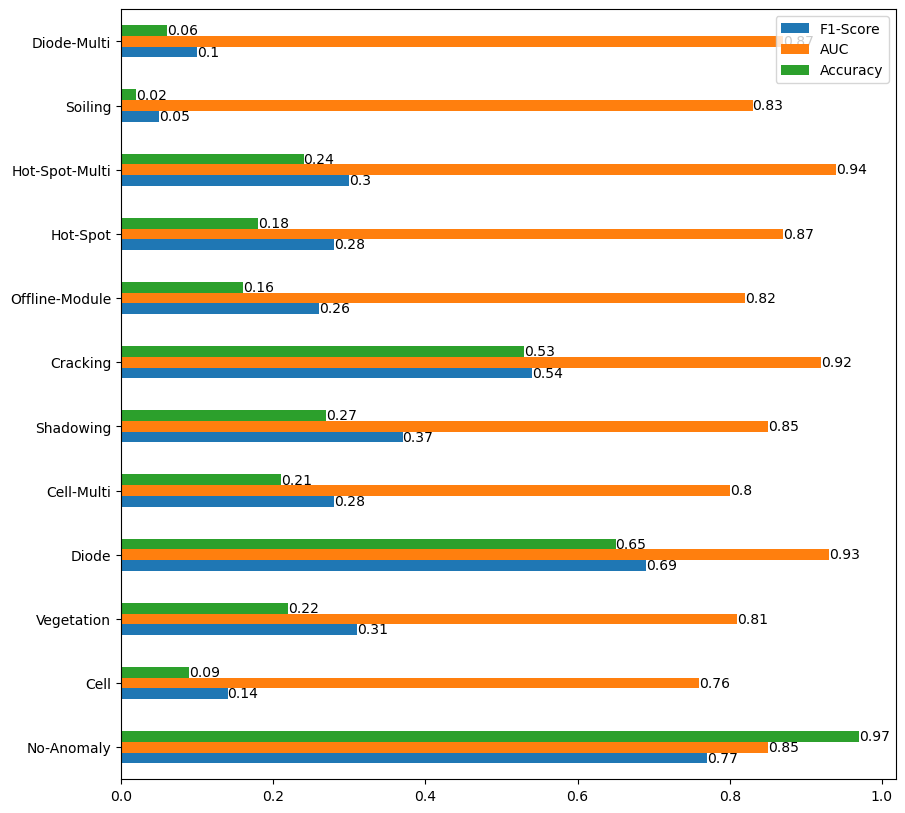

In [218]:
train_test_mobile.test()
train_test_mobile.plot_confusion_matrix()
train_test_mobile.plot_class_metrics()

# Pretrained Transformer

In [220]:
def preprocess_vit(image, aug_number=0, label=None):
    image_list = []

    # Define transformations for augmentation
    transforms_list = [
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.RandomVerticalFlip(p=0.15),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    # Define plain forward
    transforms_plain = [
        transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    ]

    if aug_number == 0:
        image_list.append(transforms_plain[0](Image.fromarray(image)).numpy())
    else:
        for _ in range(aug_number):
            img_aug = transforms_list[0](Image.fromarray(image)).numpy()
            image_list.append(img_aug)

    return image_list

In [222]:
input_dim = (3, 224, 224)
weights_vit = torchvision.models.ViT_B_16_Weights.DEFAULT
model_vit = torchvision.models.vit_b_16(weights=weights_vit)
for p in model_vit.parameters():
    p.requires_grad = False

heads_vit = nn.Sequential(
    nn.Linear(768, 800),
    nn.ReLU(),
    nn.Dropout(0.50),
    nn.Linear(800, 500),
    nn.ReLU(),
    nn.Linear(500, 12),
)
model_vit.heads = heads_vit

summary(model_vit, input_size=(1, input_dim[0], input_dim[1], input_dim[2]))

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 12]                   768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [223]:
loss_vit = nn.BCEWithLogitsLoss().to(device)
optimizer_vit = torch.optim.Adam(model_vit.parameters(), lr=0.0001)
train_test_vit = utils.TrainTest(
    model_vit.to(device),
    loss_vit,
    32,
    solar_dataset,
    solar_dataset.train_df,
    device,
    pre_process=preprocess_vit,
    augment=False,
)

Loss = 0.16979687610268593   Accuracy= 0.58925
Best Epoch # 0  Validation Loss= 0.16979687610268593  Validation Accu= 0.58925
Loss = 0.15589856925606727   Accuracy= 0.6175
Best Epoch # 1  Validation Loss= 0.15589856925606727  Validation Accu= 0.6175
Loss = 0.14555183163285254   Accuracy= 0.66525
Best Epoch # 2  Validation Loss= 0.14555183163285254  Validation Accu= 0.66525
Loss = 0.1386986622810364   Accuracy= 0.67325
Best Epoch # 3  Validation Loss= 0.1386986622810364  Validation Accu= 0.67325
Loss = 0.13465819495916367   Accuracy= 0.686
Best Epoch # 4  Validation Loss= 0.13465819495916367  Validation Accu= 0.686
Loss = 0.13145291398465633   Accuracy= 0.68875
Best Epoch # 5  Validation Loss= 0.13145291398465633  Validation Accu= 0.68875
Loss = 0.13141861748695374   Accuracy= 0.69725
Best Epoch # 6  Validation Loss= 0.13141861748695374  Validation Accu= 0.69725
Loss = 0.12603077322244643   Accuracy= 0.70175
Best Epoch # 7  Validation Loss= 0.12603077322244643  Validation Accu= 0.70175


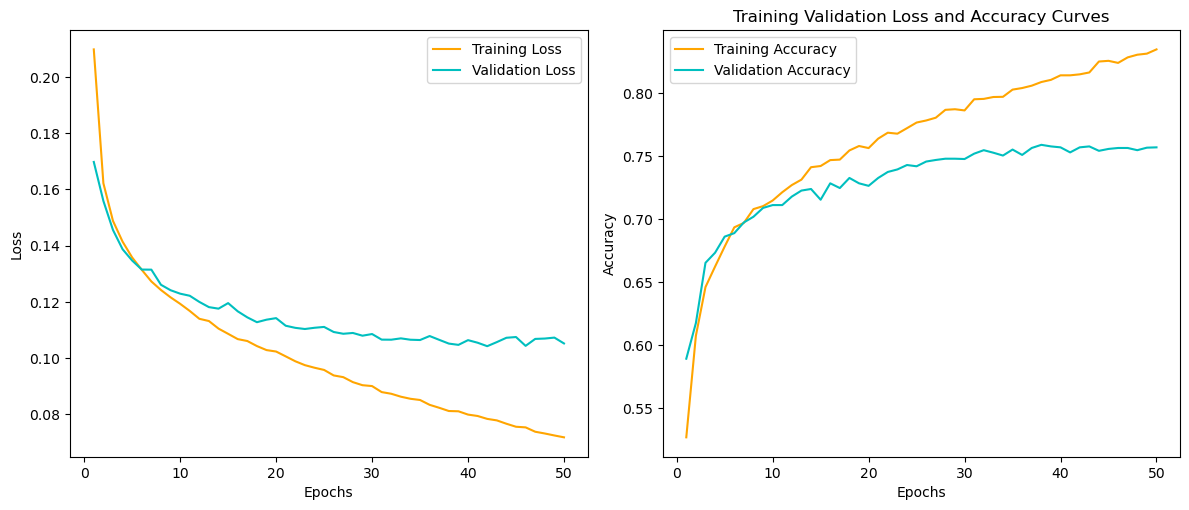

In [224]:
# Train Model
our_best_vit_loss, our_best_vit_accuracy, our_best_vit_epoch = train_test_vit.train(optimizer_vit, 50, "resnet_model_vit.pth")

Loss = 0.10512684205919504   Accuracy= 0.75675


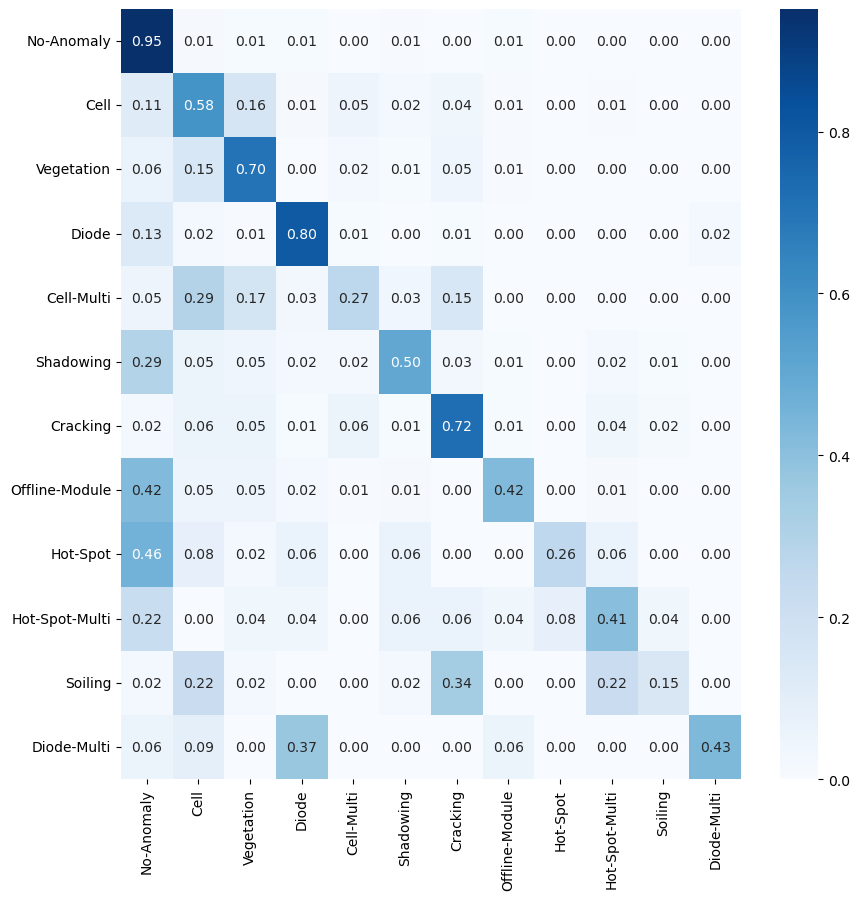

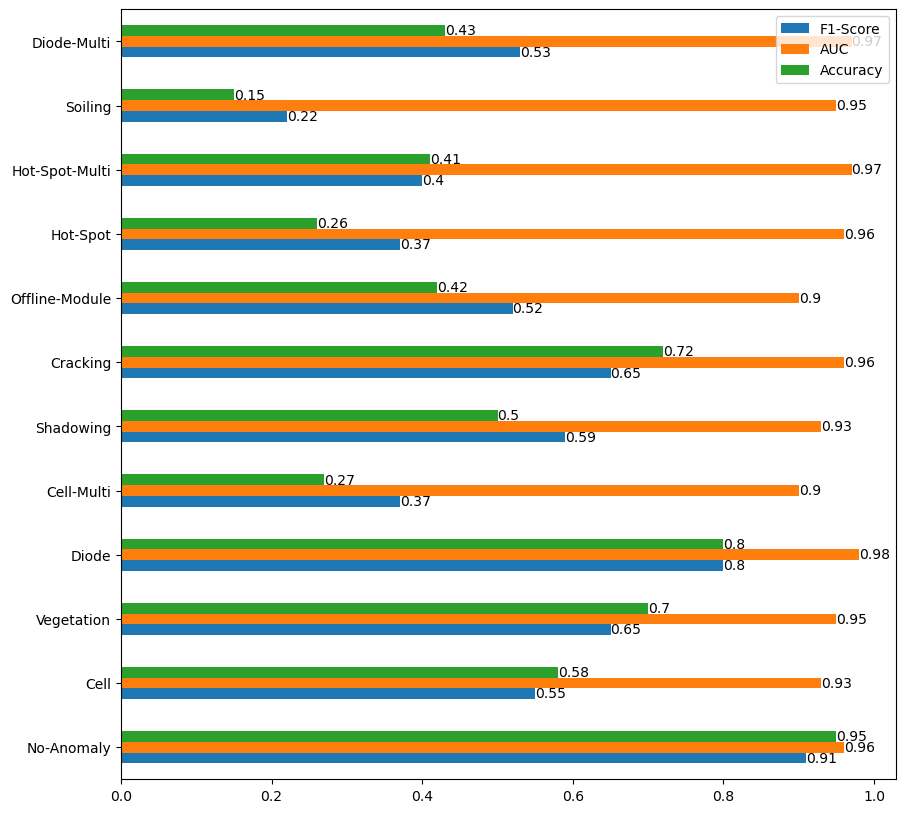

In [225]:
train_test_vit.test()
train_test_vit.plot_confusion_matrix()
train_test_vit.plot_class_metrics()

# Results and discussion

| Type | # Params | Acc Train | Acc Test |
| ---- | -------- | --------- | -------- |
| CNN from Paper (no data aug.) | 2.757.868 | 0.95 | 0.79 |
| Our CNN (no data aug.) | 2.526.852 | 0.95 | 0.80 |
| Class Sensitive (no data aug.) | 2.526.852 | 0.90 | 0.78 |
| Traditional data aug. | 2.526.852 | 0.99 | 0.80 |
| Traditional + GAN data aug. | 2.526.852 | 0.99 | 0.80 |
| MobileNet v2 | 3.655.484 | 0.65 | 0.63 |
| Transformer | 86.820.368 | 0.85 | 0.76 |
| Original Paper | 2.760.268 | 0.92 | 0.85 |

# Conclusions


The comprehensive exploration and analysis of various models, pre-processing techniques, and fine-tuning strategies presented in this study aimed to address the challenges posed by a highly unbalanced dataset in the context of anomaly detection in solar panel images.
As can be seen, we used several models, quite diverse, where we also introduced some pre-processing techniques, tested through different neural networks and pre-trained models where we fine tuned them to obtain the best possible results.
The fact that we had a very unbalanced dataset had a strong impact on our work. Data balancing techniques were needed to obtain the best results, but they required a great deal of computational effort, as was the case with GAN (generative adversarial networks).
The images classified as Diode-Multi, Hot-Spot, Hot-Spot-Multi and soiling were always the most difficult to train, but ultimately we have succeeded in identifying these types of image.
The results of the paper served as a basis for us to set objectives and at the same time understand what were good and bad values for our evaluation metrics. The best results were the detection of No Anomaly (98%) and Diode (95%) and, on the negative side, the predicted anomalies were around 50% or lower Cell-Multi (51%), Hot-Spot-Multi (59%) and Soiling (37%).
When comparing the results, we concluded that the model with 60% oversample + 40% generative adversarial networks was the one that obtained the most positive results, with a test accuracy of 81.15%, with very good results in the classification of Diode-Multi (86%), Diode (92%) and No Anomaly (97%), while the anomalies Soiling (27%) and Cell-Multi (40%) were a real challenge. Overall, we consider this model to be more successful on average than the benchmark paper.
Among the models used, the one that ended up with the worst performance was the one fulfilling condition B (adding class sensitive learning), as well as having the lowest accuracy (77%), it also showed poor results in classifying the four anomalies Soiling (12%), Hot-Spot-Multi (35%), Cell-Multi (32%) and Hot-Spot (36%), this model shows a tremendous failure in detecting these classifications and its false predictions are directed towards No Anomaly, for example in the confusion matrix we see that 52% of the Hot-Spot errors are due to having classified it as No-Anomaly.
Regarding the pre-trained models, there was an higher expectation of their performance, even without updating all their wights - most of the blocks were freezed due to the lack of computational resources. For so well knowned models, having an accuracy of 63% in test was disappointing, however we believe that we can optimized ResNet and MobileNet, but specially the first one, and have better performace.
Unlike the pre-trained models, the expectation for the visual transformer(VIT) wasnt so high since usually good CNN architectures can perform better than the VIT. Although, VIT has an accuracy in test of 76% most of this good performance is due to the classes with more samples (as all of the other pre-trained) failling completly with the classes with less samples (it was prediction No Anomaly instead).

# References

https://www.sciencedirect.com/science/article/pii/S0263224123006991?via%3Dihub

https://openaccess.thecvf.com/content/CVPR2021/papers/Li_On_Feature_Normalization_and_Data_Augmentation_CVPR_2021_paper.pdf

https://arxiv.org/abs/2103.15158

https://arxiv.org/pdf/2010.11929.

https://www.frontiersin.org/articles/10.3389/fdata.2021.659146/full

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8253599

https://www.sciencedirect.com/science/article/abs/pii/S0957417417306346

https://www.foldl.me/uploads/2015/conditional-gans-face-generation/paper.

https://github.com/soumith/

https://arxiv.org/pdf/1511.06434.pdf

https://www.sciencedirect.com/science/article/abs/pii/S0957417417306346